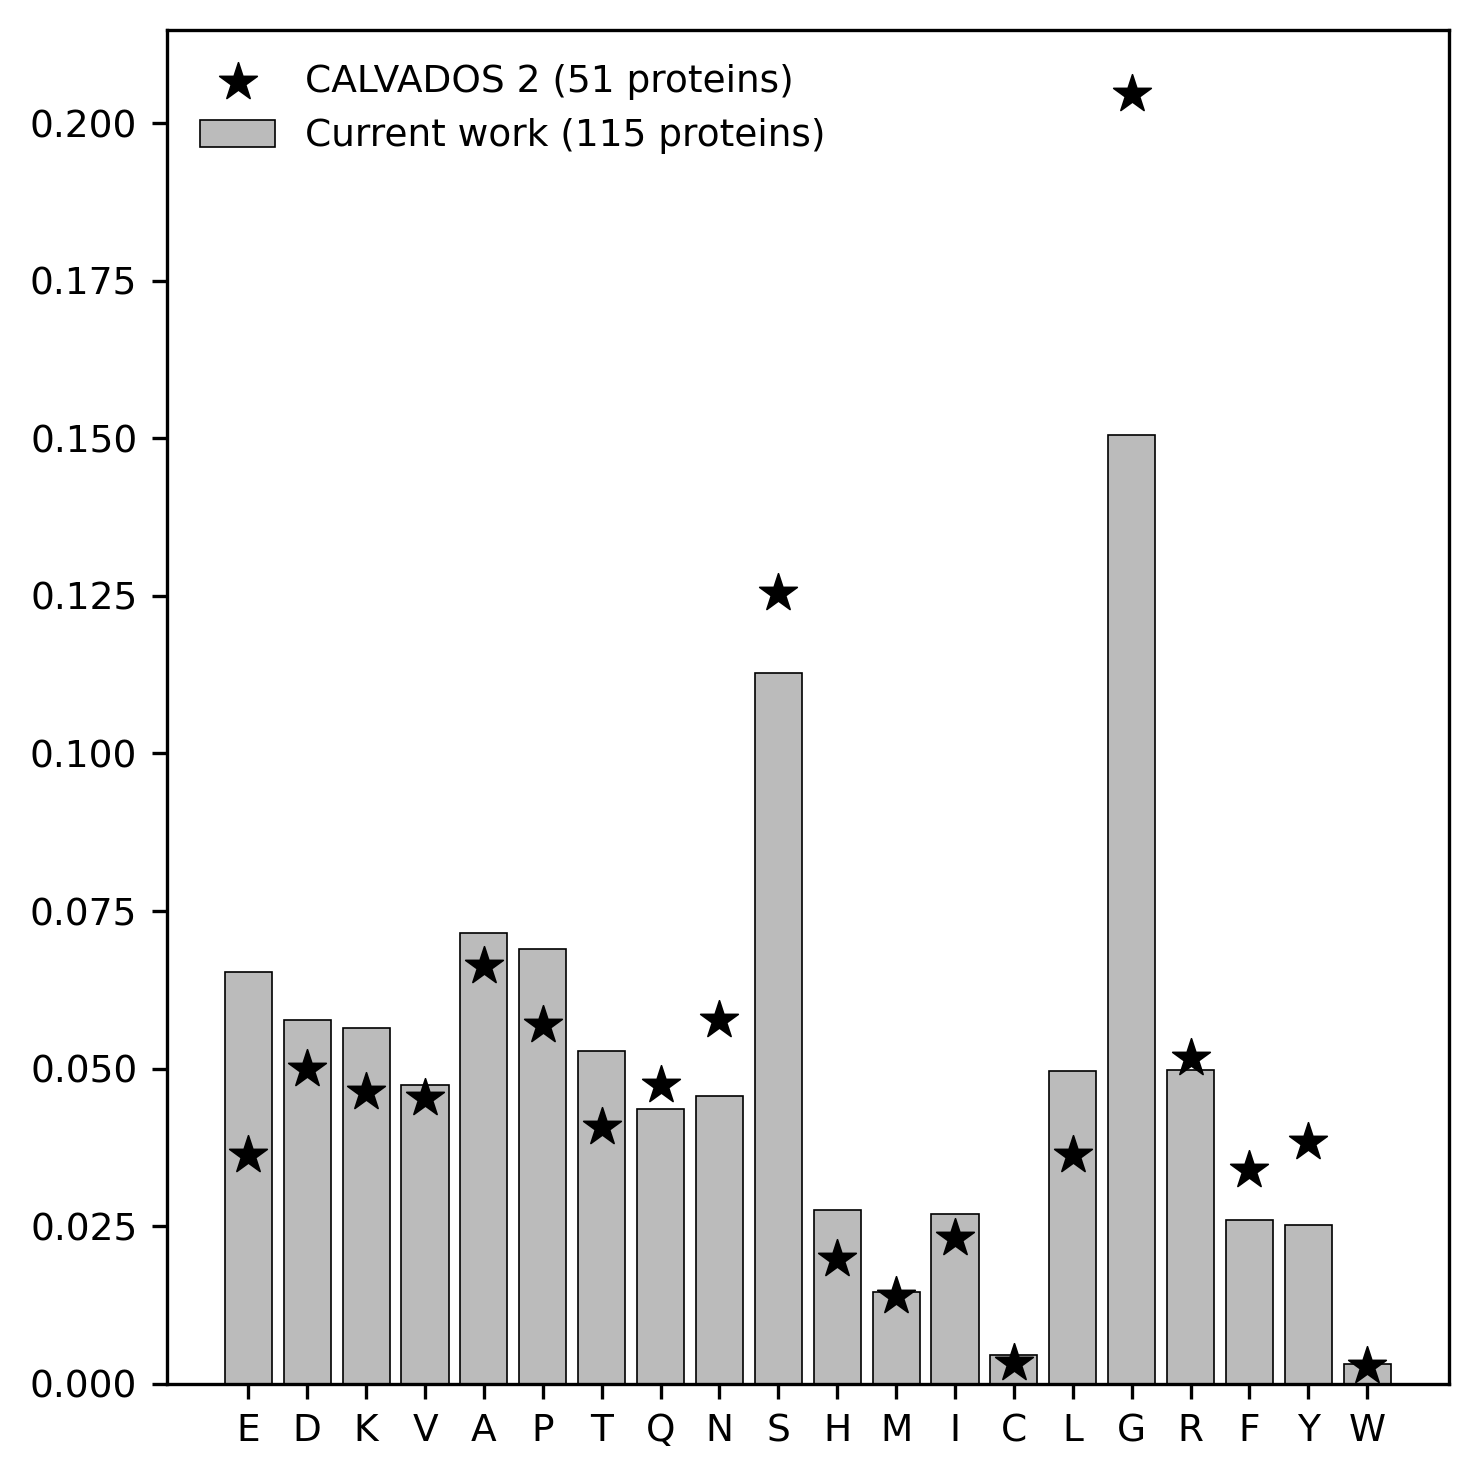

In [13]:
from collections import defaultdict
from color_setting import *
text_size = 9
label_size = text_size*1.5
s = 30
linewidth = 0.1
times = 1000
mpl.rc('font', size=text_size)
string_chi2_rg = "$\\langleχ^2_{R_g}\\rangle$"
string_chi2_saxs = "$\\langleχ^2_{SAXS}\\rangle$"
string_chi2_pre =  "$\\langle\chi^2_{PRE}\\rangle$"
string_chi2_fret =  "$\\langle\chi^2_{FRET}\\rangle$"
string_prior = "prior"

def comparison_numRes():
    cwd = "/projects/prism/people/ckv176/_2026_cao_scales/src"
    residues_pub = pd.read_csv(f"{cwd}/residues_pub.csv").set_index("one").sort_values("CALVADOS2")
    fig = plt.figure(figsize=(5, 5), dpi=300)
    ax2 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)

    numdict_C2 = defaultdict(int)
    numdict_new = defaultdict(int)
    C2_dataset = pd.concat((pd.read_pickle(f"{cwd}/IDPsRgs_C2.pkl"), pd.read_pickle(f"{cwd}/proteinsPRE_C2.pkl")))
    new_dataset = pd.read_pickle(f"{cwd}/data/IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1/proteinsRgs.pkl")
    pools_C2 = []
    for record in C2_dataset.index:
        pools_C2 += C2_dataset.loc[record, "fasta"]

    pools_new = []
    for record in new_dataset.index:
        pools_new += new_dataset.loc[record, "fasta"]




    count_C2 = 0
    count_new = 0
    for aa in residues_pub.index:
        numdict_C2[aa] = pools_C2.count(aa)
        count_C2 += pools_C2.count(aa)
        numdict_new[aa] = pools_new.count(aa)
        count_new += pools_new.count(aa)
    assert count_C2 == len(pools_C2)
    assert count_new == len(pools_new)

    ax2.bar(residues_pub.index, [numdict_new[aa] / count_new for aa in residues_pub.index], label="Current work (115 proteins)", color=grey, edgecolor="black", linewidth=linewidth * 4)
    ax2.scatter(residues_pub.index, [numdict_C2[aa] / count_C2 for aa in residues_pub.index], label="CALVADOS 2 (51 proteins)", color="black", marker="*", edgecolor="black", linewidth=linewidth * 4, s=s * 3)
    # ax2.set_title("Residue Rat.")
    ax2.legend(edgecolor="white", frameon=False)

    plt.tight_layout()
    plt.savefig(f"{cwd}/comparison_numRes.pdf")
    plt.show()



comparison_numRes()

IDPsresetErrC2_priorNominmaxCAC2_based_2.4_150.0_0.5_1_validate
IDPsresetErrC2_priorNominmaxCAC2_based_2.4_150.0_0.5_2_validate
IDPsresetErrC2_priorNominmaxCAC2_based_2.4_150.0_0.5_3_validate
theta: 150
combine_rg []
opt_loss [86.90069874 85.01211699 81.72627733]
optprior_pool [55.29937670239267, 53.38859365812508, 49.89506666913847]
optRg_pool [31.60132203265825, 31.62352332996478, 31.831210660625857]
valRg_pool [82.63377661133657, 83.71058056700049, 80.40134702519909]
valPre_pool [221.0739619500068, 195.98773163057805, 215.37353933946318]
valFret_pool [46.68322101793589, 51.68856239726117, 48.96559479547577]
valFretEstatic_pool [94.5986020225606, 89.84931260119356, 91.2547958801545]
valFretEdynamic1_pool [25.03829363517293, 24.39390494210409, 24.309363707793867]
IDPsresetErrC2_priorNominmaxCAC2_based_2.4_450.0_0.5_1_validate
IDPsresetErrC2_priorNominmaxCAC2_based_2.4_450.0_0.5_2_validate
IDPsresetErrC2_priorNominmaxCAC2_based_2.4_450.0_0.5_3_validate
theta: 450
combine_rg [104.161641

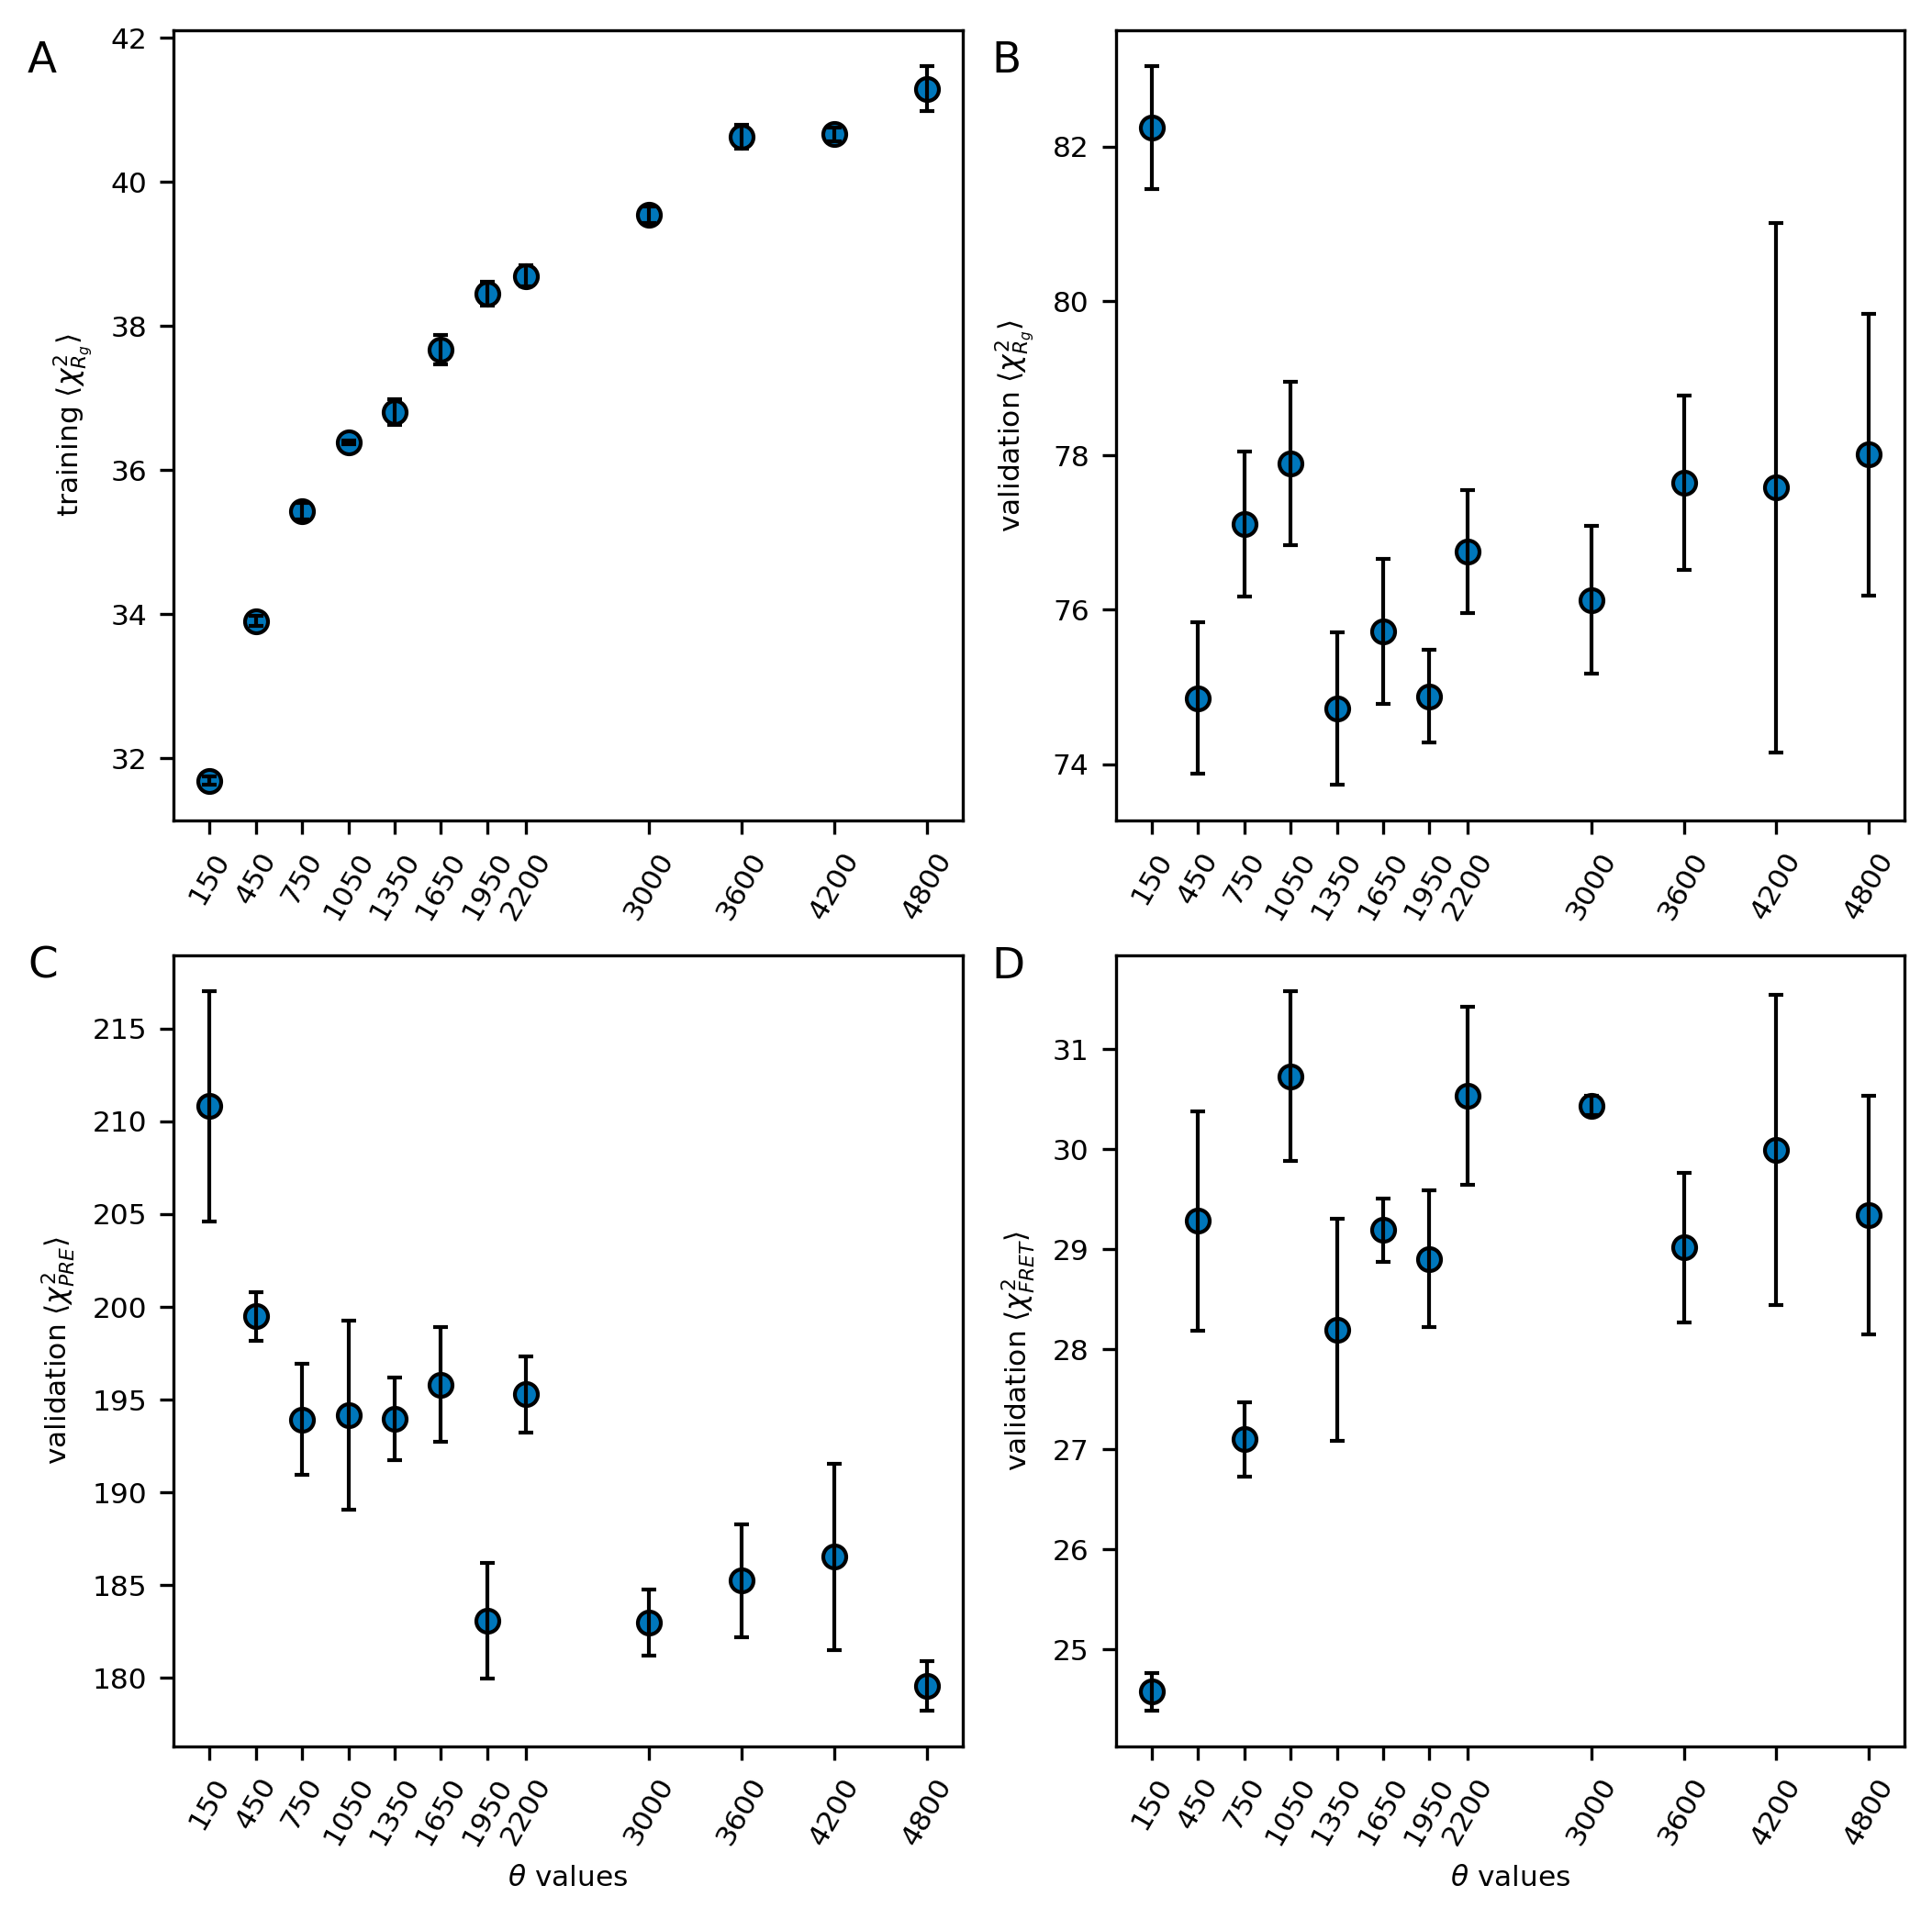

In [5]:
import numpy as np
import pandas as pd
import statsmodels.regression.linear_model as sm
from FRETpredict import FRETpredict
from ast import literal_eval
import shutil
import os
import ray
from color_setting import *
from collections import OrderedDict
from DEERPREdict.utils import Operations
from DEERPREdict.PRE import PREpredict
import MDAnalysis
text_size = 7.5
label_size = text_size*1.5
s = 30
linewidth = 0.1
times = 1000
mpl.rc('font', size=text_size)
string_chi2_rg = "$\\langleχ^2_{R_g}\\rangle$"
string_chi2_saxs = "$\\langleχ^2_{SAXS}\\rangle$"
string_chi2_pre =  "$\\langle\chi^2_{PRE}\\rangle$"
string_chi2_fret =  "$\\langle\chi^2_{FRET}\\rangle$"
string_prior =  "prior"


def get_predictions_opt(cwd, dataset, cycle):
    allproteins = pd.read_pickle(f"{cwd}/data/{dataset}/allproteins.pkl")
    IDP_names = list(allproteins.index)
    cal = []
    allproteins = allproteins.loc[IDP_names]
    for name in allproteins.index:
        if not os.path.isfile(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy"):
            df = pd.read_csv(f'{cwd}/data/{dataset}/residues_{cycle}.csv').set_index('three')
            t = md.load_dcd(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.dcd",
                            f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.pdb")
            residues = [res.name for res in t.top.atoms]
            masses = df.loc[residues, 'MW'].values
            masses[0] += 2
            masses[-1] += 16
            # calculate the center of mass
            cm = np.sum(t.xyz * masses[np.newaxis, :, np.newaxis], axis=1) / masses.sum()
            # calculate residue-cm distances
            si = np.linalg.norm(t.xyz - cm[:, np.newaxis, :], axis=2)
            # calculate rg
            rgarray = np.sqrt(np.sum(si ** 2 * masses, axis=1) / masses.sum())
            np.save(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy", rgarray)

        else:
            rgarray = np.load(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy")
        cal_value = np.mean(rgarray)
        cal.append(cal_value)

    allproteins["cal"] = cal
    allproteins['N'] = allproteins['fasta'].apply(lambda x: len(x))
    allproteins = allproteins.sort_values('N', ascending=False)
    allproteins.to_pickle(f"{cwd}/data/{dataset}/predictions.pkl")

    return allproteins, IDP_names

def reweightSAXS(prot, weights=None):
    # weighted saxs
    if isinstance(weights, np.ndarray):
        assert len(weights) == len(prot.calSAXS)  # (4000, n_points) for SAXSdata[:,:,3]
        cal = np.sum(prot.calSAXS.T * weights, axis=1)
    else:
        cal = np.mean(prot.calSAXS, axis=0)
    # error = prot.expSAXSErr  # sigma, without normalization
    cal = np.vstack([cal, np.ones(len(cal))]).T
    # weighted LS:
    res = sm.WLS(prot.expSAXS, cal, weights=1.0 / np.power(prot.expSAXSErr, 2)).fit()
    rescaleSAXS = res.predict(cal)
    assert len(prot.expSAXS) == len(rescaleSAXS)
    # calculate chi2_saxs
    q_chi2SAXS = np.power((rescaleSAXS-prot.expSAXS)/prot.expSAXSErr,2)
    chi2_SAXS = q_chi2SAXS.mean()  # sum over all q points
    return rescaleSAXS, chi2_SAXS

def initSAXS(cwd, dataset, cycle, SAXS_proteins, include_SAXSloss=True):
    proteins = pd.DataFrame(columns=['q','expSAXS','expSAXSErr','calSAXS','rescaleSAXS','eff','chi2_SAXS','weights'],dtype=object)
    if include_SAXSloss:
        for seq_name in SAXS_proteins:
            SAXSdata = pd.read_pickle(f"{cwd}/data/{dataset}/{seq_name}/{cycle}/{seq_name}_SAXS.pkl").astype(object)  # (4000,n_points,4)
            proteins.loc[seq_name] = dict(q=SAXSdata.loc[0].q, expSAXS=SAXSdata.loc[0].expSAXS, expSAXSErr=SAXSdata.loc[0].expSAXSErr, calSAXS=np.array([i for i in SAXSdata.calSAXS.values]))
    return proteins

def loadInitPREs(cwd, dataset, record, cycle, prot):
    obs = 1 if prot.obs=='ratio' else 2
    value = {}
    resnums = np.arange(1,len(prot.fasta)+1)
    for label in prot.labels:
        value[label] = np.loadtxt(f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs/res-{label}.dat')[:,obs]
    v = pd.DataFrame(value,index=resnums)
    v.rename_axis('residue', inplace=True)
    v.rename_axis('label', axis='columns',inplace=True)
    return v

def calcChi2(cwd, dataset, record, cycle, prot):
    obs = 1 if prot.obs=='ratio' else 2
    chi2 = 0
    for label in prot.labels:
        y = np.loadtxt(f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs/res-{label}.dat')[:,obs]
        chi = (prot.expPREs.value[label].values - y) / prot.expPREs.error[label].values
        chi = chi[~np.isnan(chi)]
        chi2 += np.nansum( np.power( chi, 2) ) / chi.size
    return chi2 / len(prot.labels)

def optTauC(cwd, dataset, record, cycle, prot):
    obs = 1 if prot.obs == 'ratio' else 2
    chi2list = []
    tau_c = np.arange(2,10.05,1)
    for tc in tau_c:
        chi2 = 0
        for label in prot.labels:
            # the first two columns in res-{label}.dat
            x,y = np.loadtxt(f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs/res-{label}.dat',usecols=(0,1),unpack=True)
            # x: [  1.   2.   3. ... 218. 219. 220.] (number of residue)
            # y: [nan 0.14382832 0.28971916 ... 0.99804923 0.99705705 0.99578599] (number of residue)

            # index of residues with a real value (start with 0)
            measured_resnums = np.where(~np.isnan(y))[0]
            data = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs/res-{label}.pkl', compression='gzip')
            # the reason why nan shows up is that the corresponding steric partition function is under cutoff.
            # So it is discarded
            # print(data)
            # r3[[nan, ... nan], ... [1.47580169e-04, ... 3.25930228e-06]]  (traj_len, measured_resnums_len)
            # r6 similar to r3, but distributions of nan are not necessarily the same
            # angular the similar as the above
            # print(data.index)  Index(['r3', 'r6', 'angular'], dtype='object')
            gamma_2_av = np.full(y.size, fill_value=np.NaN)
            s_pre = np.power(data['r3'], 2)/data['r6']*data['angular']  # calculate following the formula
            gamma_2 = Operations.calc_gamma_2(data['r6'], s_pre, tau_c = tc * 1e-9, tau_t = 1e-10, wh = prot.wh, k = 1.23e16)  # calculate following the formula
            # print(gamma_2.shape)  (traj_len, measured_resnums_len)
            gamma_2 = np.ma.MaskedArray(gamma_2, mask = np.isnan(gamma_2))
            gamma_2_av[measured_resnums] = np.ma.average(gamma_2, axis=0).data  # averaged over traj
            # For samples with particularly high PRE rates it can be infeasible to obtain Γ2 from 174 multiple time-point measurements,
            # https://doi.org/10.1101/2020.08.09.243030
            if prot.obs == 'ratio':
                y = 10 * np.exp(-gamma_2_av * 0.01) / ( 10 + gamma_2_av )
            else:
                y = gamma_2_av

            # calculate chi
            chi = (prot.expPREs.value[label].values - y) / prot.expPREs.error[label].values
            chi = chi[~np.isnan(chi)]
            chi2 += np.nansum( np.power( chi, 2) ) / chi.size
        chi2list.append(chi2 / len(prot.labels))

    tc_min = tau_c[np.argmin(chi2list)]  # pick up the smallest value

    for label in prot.labels:
        x,y = np.loadtxt(f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs/res-{label}.dat',usecols=(0,1),unpack=True)
        measured_resnums = np.where(~np.isnan(y))[0]
        data = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs/res-{label}.pkl', compression='gzip')
        gamma_2_av = np.full(y.size, fill_value=np.NaN)
        s_pre = np.power(data['r3'], 2)/data['r6']*data['angular']
        gamma_2 = Operations.calc_gamma_2(data['r6'], s_pre, tau_c = tc_min * 1e-9, tau_t = 1e-10, wh = prot.wh, k = 1.23e16)
        gamma_2 = np.ma.MaskedArray(gamma_2, mask = np.isnan(gamma_2))
        gamma_2_av[measured_resnums] = np.ma.average(gamma_2, axis=0).data
        i_ratio = 10 * np.exp(-gamma_2_av * 0.01) / ( 10 + gamma_2_av )
        np.savetxt(f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs/res-{label}.dat',np.c_[x,i_ratio,gamma_2_av])

    return tc_min, calcChi2(cwd, dataset, record, cycle, prot)


@ray.remote(num_cpus=1)
def evaluatePRE(cwd, dataset, label, record,cycle, prot, log_path):
    if not os.path.isdir(f"{cwd}/data/{dataset}/{log_path}/{record}"):
        os.system(f"mkdir -p {cwd}/data/{dataset}/{log_path}/{record}")

    prefix = f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs/res'
    filename = prefix+'-{:d}.pkl'.format(label)
    if isinstance(prot.weights, np.ndarray):
        u = MDAnalysis.Universe(f'{cwd}/data/{dataset}/{record}/{cycle}/allatom.pdb')
        load_file = filename
    elif isinstance(prot.weights, bool) or isinstance(prot.weights, np.bool_):  # different from original code
        u = MDAnalysis.Universe(f'{cwd}/data/{dataset}/{record}/{cycle}/allatom.pdb',f'{cwd}/data/{dataset}/{record}/{cycle}/allatom.dcd')  # Å
        load_file = False
    else:
        raise ValueError('Weights argument is a '+str(type(prot.weights)))
    PRE = PREpredict(u, label, log_file=f'{cwd}/data/{dataset}/{log_path}/{record}/log', temperature=prot.temp, atom_selection='N', sigma_scaling=1.0)
    PRE.run(output_prefix=prefix, weights=prot.weights, load_file=load_file, tau_t=1e-10, tau_c=prot.tau_c*1e-09, r_2=10, wh=prot.wh)

def loadExpPREs(cwd,dataset, record,prot):
    value = {}
    error = {}
    resnums = np.arange(1,len(prot.fasta)+1)
    for label in prot.labels:
        value[label], error[label] = np.loadtxt(f'{cwd}/data/{dataset}/{record}/expPREs/exp-{label}.dat',unpack=True)
    v = pd.DataFrame(value,index=resnums)
    v.rename_axis('residue', axis='index', inplace=True)
    v.rename_axis('label', axis='columns',inplace=True)
    e = pd.DataFrame(error,index=resnums)
    e.rename_axis('residue', axis='index', inplace=True)
    e.rename_axis('label', axis='columns',inplace=True)
    return pd.concat(dict(value=v,error=e),axis=1)

def get_Rgpredictions(cwd, dataset, cycle, Rg_seq):
    allproteins = pd.read_pickle(f"{cwd}/data/{dataset}/allproteins_validate.pkl")
    cal = []
    for name in allproteins.index:
        if name in Rg_seq:
            # os.system(f"mkdir -p /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}/{name}/{cycle + 1}")
            # os.system(f"cp /projects/prism/people/ckv176/stickiness/src/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}/{name}/{cycle + 1}")
            if not os.path.isfile(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy"):
                df = pd.read_csv(f'{cwd}/data/{dataset}/residues_{cycle}.csv').set_index('three')
                t = md.load_dcd(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.dcd",
                                f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.pdb")
                residues = [res.name for res in t.top.atoms]
                masses = df.loc[residues, 'MW'].values
                masses[0] += 2
                masses[-1] += 16
                # calculate the center of mass
                cm = np.sum(t.xyz * masses[np.newaxis, :, np.newaxis], axis=1) / masses.sum()
                # calculate residue-cm distances
                si = np.linalg.norm(t.xyz - cm[:, np.newaxis, :], axis=2)
                # calculate rg
                rgarray = np.sqrt(np.sum(si ** 2 * masses, axis=1) / masses.sum())
                np.save(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy", rgarray)
            else:
                rgarray = np.load(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy")
        else:
            rgarray = []
        cal_value = np.mean(rgarray)
        cal.append(cal_value)

    allproteins["cal"] = cal
    allproteins['N'] = allproteins['fasta'].apply(lambda x: len(x))
    allproteins = allproteins.sort_values('N', ascending=False)

    allproteins_validate = allproteins.loc[Rg_seq]
    allproteins_validate["reset_ratio"] = allproteins_validate["expRgErr"] / allproteins_validate["expRg"]
    # print(allproteins_validate[["expRg", "cal", "expRgErr", "reset_ratio"]], allproteins_validate.index)
    allproteins_validate["chi2_rg"] = np.power((allproteins_validate["cal"]-allproteins_validate["expRg"])/allproteins_validate["expRgErr"], 2)

    allproteins_validate.to_pickle(f"{cwd}/data/{dataset}/predictions.pkl")

    return allproteins_validate

def generatePREloss(cwd, dataset, cycle):
    if not os.path.exists(f"{cwd}/data/{dataset}/proteinsPRE_complete{cycle}.pkl"):
        proteinsPRE = pd.read_pickle(f'{cwd}/data/{dataset}/proteinsPRE_validate.pkl').astype(object)  # can read an empty dataframe
        proteinsPRE["weights"] = False  # pandas needs to be 1.5.2 or above!!!!!!!!
        for record in proteinsPRE.index:
            # tau_c, chi2_pre = optTauC(cwd, dataset, record, cycle, proteinsPRE.loc[record])
            tmp_pkl = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/proteinsPRE_validate_{record}.pkl')
            proteinsPRE.at[record,'tau_c'] = tmp_pkl["tau_c"]
            proteinsPRE.at[record,'chi2_pre'] = tmp_pkl["chi2_pre"]
            proteinsPRE.at[record,'initPREs'] = tmp_pkl["initPREs"]
            if os.path.exists(f'{cwd}/data/{dataset}/{record}/{cycle}/initPREs'):
                shutil.rmtree(f'{cwd}/data/{dataset}/{record}/{cycle}/initPREs')  # delete files recursively
            shutil.copytree(f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs',f'{cwd}/data/{dataset}/{record}/{cycle}/initPREs')  # copy dir
        proteinsPRE.to_pickle(f"{cwd}/data/{dataset}/proteinsPRE_complete{cycle}.pkl")

def generateFRETloss(cwd, dataset, cycle, new=False):
    fret_err = 0.02
    if not new:
        df_rg = pd.read_csv(f'{cwd}/rg_test_data.csv', index_col=0)
        df_rg = df_rg.sort_values('N', ascending=False)
        df_rg.rel_rg_err_replicas = df_rg.rel_rg_err_replicas.apply(lambda x: literal_eval(x))
        df_ped = pd.read_csv(f'{cwd}/PED_data.csv',index_col=0)
        df_ped.loc[df_ped.drop('p27Kip1').index,'exp_rg'] = df_rg.loc[df_ped.drop('p27Kip1').index,'exp_rg']
        df_ped.loc[df_ped.drop('p27Kip1').index,'exp_rg_err'] = df_rg.loc[df_ped.drop('p27Kip1').index,'exp_rg_err']
        for Edynamic in ["Estatic", "Edynamic1", "Edynamic2"]:
            if not os.path.exists(f"{cwd}/data/{dataset}/proteinsFRET20_complete_{Edynamic}_{cycle}.pkl"):
                df_eff = pd.DataFrame(index=['Nup49', 'NLS', 'NUS', 'IBB', 'NUL', 'Sic1'])
                for name, exp_E in zip(['Nup49', 'NLS', 'NUS', 'IBB', 'NUL'], [.87, .79, .53, .5, .48]):
                    record = name
                    df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret-data-{df_ped.loc[name].N - 1:d}-2.pkl').loc[Edynamic, 'Average']
                    df_eff.loc[name, 'exp_E'] = exp_E

                name = 'Sic1'
                record = name
                df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret-data-1-90.pkl').loc[Edynamic, 'Average']
                df_eff.loc[name, 'exp_E'] = 0.42  # DOI: 10.1021/jacs.0c02088
                df_eff["chi2_fret"] = np.power((df_eff["exp_E"]-df_eff["E"])/fret_err, 2)
                df_eff.to_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_{Edynamic}_{cycle}.pkl")

            if not os.path.exists(f"{cwd}/data/{dataset}/proteinsFRET30_complete_{Edynamic}_{cycle}.pkl"):
                df_eff = pd.DataFrame(index=['Nup49', 'NLS', 'NUS', 'IBB', 'NUL', 'Sic1'])
                for name, exp_E in zip(['Nup49', 'NLS', 'NUS', 'IBB', 'NUL'], [.87, .79, .53, .5, .48]):
                    record = name
                    df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret30-data-{df_ped.loc[name].N - 1:d}-2.pkl').loc[Edynamic, 'Average']
                    df_eff.loc[name, 'exp_E'] = exp_E

                name = 'Sic1'
                record = name
                df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret30-data-1-90.pkl').loc[Edynamic, 'Average']
                df_eff.loc[name, 'exp_E'] = 0.42  # DOI: 10.1021/jacs.0c02088
                df_eff["chi2_fret"] = np.power((df_eff["exp_E"]-df_eff["E"])/fret_err, 2)
                df_eff.to_pickle(f"{cwd}/data/{dataset}/proteinsFRET30_complete_{Edynamic}_{cycle}.pkl")
    else:
        more_fret = pd.read_pickle(f'{cwd}/proteins_fret.pkl')
        for Edynamic in ["Estatic", "Edynamic1", "Edynamic2"]:
            if not os.path.exists(f"{cwd}/data/{dataset}/proteinsFRET10_complete_{Edynamic}_{cycle}.pkl"):
                df_eff = pd.DataFrame(index=list(more_fret.index))
                for name, exp_E in zip(list(more_fret.index), more_fret.loc[list(more_fret.index), 'EC']):
                    record = name
                    df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret10-data-{more_fret.loc[record].labels[0]}-{more_fret.loc[record].labels[-1]}.pkl').loc[Edynamic, 'Average']
                    df_eff.loc[name, 'exp_E'] = exp_E
                    df_eff.loc[name, 'fret_err'] = more_fret.loc[record, "EC_err"]
                df_eff["chi2_fret"] = np.power((df_eff["exp_E"] - df_eff["E"]) / df_eff["fret_err"], 2)
                df_eff.to_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_{Edynamic}_{cycle}.pkl")
def crossvalidation():
    # cwd = "/projects/prism/people/ckv176/stickiness/src"
    cwd = "/projects/prism/people/ckv176/_2026_cao_scales/src"
    fig = plt.figure(figsize=(7, 7), dpi=300)
    ax4 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
    ax1 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)
    ax_list = [ax1, ax2, ax3, ax4]
    thetas = list(range(150, 2100, 300))+[2200, 3000, 3600, 4200, 4800]
    # thetas = list(range(150, 460, 300))
    replica_range = [1, 2, 3]
    # replica_range = [1]
    cycle = 0
    # thetas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
    # validateRg_pro = ["V2", "V3", "V4", "V5", "ER_NTD", "CTR_XRCC4", "Nlp441_543", "CTir", "TRPV4", "Red1", "dChMINUS_Rg", "sNhPLUS_Rg", 'ERNTD_WT', 'HMPVP_NTD', 'SMAD4_linker', 'SMAD2_linker', 'NLS_Rg', 'IBB_Rg', 'NUL_Rg', 'NUS_Rg', 'Nsp1_Rg', 'Nup49_Rg', 'N98_Rg']
    validateRg_pro =   ["V2", "V3", "V4", "V5", "ER_NTD", "CTR_XRCC4",               "CTir", "TRPV4", "Red1", "dChMINUS_Rg", "sNhPLUS_Rg",             "HMPVP_NTD",                 'SMAD2_linker', 'NLS_Rg', 'IBB_Rg', 'NUL_Rg', 'NUS_Rg', 'Nsp1_Rg', 'Nup49_Rg', 'N98_Rg']
    validateSAXS_pro = ["V2", "V3", "V4", "V5"]
    residues_pub = pd.read_csv(f"{cwd}/residues_pub.csv").set_index("one", drop=False)
    residues_pub = residues_pub.sort_values('CALVADOS2')
    sorted_aa = residues_pub.one.tolist()
    valchi2_saxs, valchi2_saxs_err = [], []
    valchi2_rg, valchi2_rg_err = [], []
    valchi2_pre, valchi2_pre_err = [], []
    valchi2_fret, valchi2_fret_err = [], []
    valchi2_fretsum, valchi2_fretsum_err = [], []
    valchi2_fretEstatic, valchi2_fretEstatic_err = [], []
    valchi2_fretEdynamic1, valchi2_fretEdynamic1_err = [], []
    optchi2_rg, optchi2_rg_err = [], []
    optprior, optprior_err = [], []
    combine_rg, combine_rgerr = [], []
    for theta in thetas:
        valRg_pool = []
        valPre_pool = []
        valFret_pool = []
        valFretSum_pool = []
        valFretEstatic_pool = []
        valFretEdynamic1_pool = []
        optprior_pool = []
        optRg_pool = []
        combine_pool = []
        for c_idx, replica in enumerate(replica_range):
            dataset = f"IDPsresetErrC2_priorNominmaxCAC2_based_2.4_{theta}.0_0.5_{replica}_validate"
            print(dataset)
            # os.system(f"mkdir -p /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}")
            # os.system(f"cp {cwd}/data/{dataset}/*.pkl /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}/")
            # os.system(f"cp {cwd}/data/{dataset}/residues_0.csv /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}/")
            # os.system(f"rm /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}/proteinsSAXS_cycle1.pkl")

            # os.system(f"mkdir -p /projects/prism/people/ckv176/_2026_cao_scales/src/{dataset[:-9]}")
            # os.system(f"cp {cwd}/{dataset[:-9]}/*.pkl /projects/prism/people/ckv176/_2026_cao_scales/src/{dataset[:-9]}/")
            chi2 = pd.read_pickle(f"{cwd}/{dataset[:-9]}/{cycle}_chi2.pkl")
            optRg_pool.append(chi2.loc[chi2.index[chi2.cost.argmin()], "chi2_rg"])
            optprior_pool.append(-chi2.loc[chi2.index[chi2.cost.argmin()], "theta_prior"]/theta*3500)
            generatePREloss(cwd, dataset, cycle+1)
            generateFRETloss(cwd, dataset, cycle+1)
            generateFRETloss(cwd, dataset, cycle + 1, new=True)
            validateRg = get_Rgpredictions(cwd, dataset, cycle, validateRg_pro)

            valRg_pool.append(np.mean(validateRg["chi2_rg"]))
            tmp_valRg = list(validateRg["chi2_rg"])
            num_val = len(validateRg.index)
            tmp_optRg = chi2.loc[chi2.index[chi2.cost.argmin()], "chi2_rg"]
            num_opt = len(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsRgs.pkl").index)
            combine_pool.append((validateRg["chi2_rg"].mean() + tmp_optRg + np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Estatic_{cycle + 1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Estatic_{cycle + 1}.pkl").chi2_fret)) + np.mean(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsPRE_complete{cycle+1}.pkl").chi2_pre)) / 4)

            valPre_pool.append(np.mean(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsPRE_complete{cycle+1}.pkl").chi2_pre))

            valFretSum_pool.append((np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Edynamic2_{cycle+1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Edynamic2_{cycle+1}.pkl").chi2_fret))+np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Estatic_{cycle + 1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Estatic_{cycle + 1}.pkl").chi2_fret))+np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Edynamic1_{cycle + 1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Edynamic1_{cycle + 1}.pkl").chi2_fret)))/3)

            valFret_pool.append(np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Edynamic2_{cycle+1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Edynamic2_{cycle+1}.pkl").chi2_fret)))

            valFretEstatic_pool.append(np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Estatic_{cycle + 1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Estatic_{cycle + 1}.pkl").chi2_fret)))

            valFretEdynamic1_pool.append(np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Edynamic1_{cycle + 1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Edynamic1_{cycle + 1}.pkl").chi2_fret)))
        print(f"theta: {theta}")
        print(f"combine_rg {combine_rg}")
        print(f"opt_loss {np.array(optprior_pool)+np.array(optRg_pool)}")
        print(f"optprior_pool {optprior_pool}")
        print(f"optRg_pool {optRg_pool}")
        print(f"valRg_pool {valRg_pool}")
        print(f"valPre_pool {valPre_pool}")
        print(f"valFret_pool {valFret_pool}")
        print(f"valFretEstatic_pool {valFretEstatic_pool}")
        print(f"valFretEdynamic1_pool {valFretEdynamic1_pool}")

        combine_rg.append(np.mean(combine_pool))
        combine_rgerr.append(np.std(combine_pool) / np.sqrt(len(combine_pool)))

        optprior.append(np.mean(optprior_pool))
        optprior_err.append(np.std(optprior_pool) / np.sqrt(len(optprior_pool)))

        optchi2_rg.append(np.mean(optRg_pool))
        optchi2_rg_err.append(np.std(optRg_pool)/np.sqrt(len(optRg_pool)))

        valchi2_rg.append(np.mean(valRg_pool))
        valchi2_rg_err.append(np.std(valRg_pool)/np.sqrt(len(valRg_pool)))

        valchi2_pre.append(np.mean(valPre_pool))
        valchi2_pre_err.append(np.std(valPre_pool)/np.sqrt(len(valPre_pool)))

        valchi2_fret.append(np.mean(valFret_pool))
        valchi2_fret_err.append(np.std(valFret_pool)/np.sqrt(len(valFret_pool)))

        valchi2_fretsum.append(np.mean(valFretSum_pool))
        valchi2_fretsum_err.append(np.std(valFretSum_pool) / np.sqrt(len(valFretSum_pool)))

        valchi2_fretEstatic.append(np.mean(valFretEstatic_pool))
        valchi2_fretEstatic_err.append(np.std(valFretEstatic_pool)/np.sqrt(len(valFretEstatic_pool)))

        valchi2_fretEdynamic1.append(np.mean(valFretEdynamic1_pool))
        valchi2_fretEdynamic1_err.append(np.std(valFretEdynamic1_pool)/np.sqrt(len(valFretEdynamic1_pool)))
    for ax_idx, ax in enumerate(ax_list):
        if ax_idx == 0:
            ax.scatter(thetas, valchi2_rg, label="val_"+string_chi2_rg, c=blue, edgecolor="black",linewidth=linewidth*10)
            ax.errorbar(thetas, valchi2_rg, yerr=valchi2_rg_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")
            # ax.scatter(thetas, np.array(optchi2_rg)*2, label="2*opt_"+string_chi2_rg, color=red)
            # ax.errorbar(thetas, np.array(optchi2_rg)*2, yerr=optchi2_rg_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")

            # ax.scatter(thetas, combine_rg, label="combined", c=magenta)
            # ax.errorbar(thetas, combine_rg, yerr=combine_rgerr, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")
            # ax.scatter(thetas, valchi2_saxs, label="20*"+string_chi2_saxs)
            # ax.errorbar(thetas, valchi2_saxs, yerr=valchi2_saxs_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1)
        if ax_idx == 1:
            # ax.scatter(thetas, np.array(optchi2_rg)*4.5, label="4.5*opt_"+string_chi2_rg, color=red)
            # ax.errorbar(thetas, np.array(optchi2_rg)*4.5, yerr=optchi2_rg_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")
            ax.scatter(thetas, valchi2_pre, label="val_"+string_chi2_pre, c=blue, edgecolor="black",linewidth=linewidth*10)
            ax.errorbar(thetas, valchi2_pre, yerr=valchi2_pre_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")
        if ax_idx == 2:
            # ax.scatter(thetas, np.array(optchi2_rg)*2.5, label="2.5*opt_"+string_chi2_rg, color=red)
            # ax.errorbar(thetas, np.array(optchi2_rg)*2.5, yerr=optchi2_rg_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")
            # ax.scatter(thetas, valchi2_fret, label="val_"+string_chi2_fret+"Edynamic2", c=blue)
            # ax.errorbar(thetas, valchi2_fret, yerr=valchi2_fret_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")

            # ax.scatter(thetas, valchi2_fretEstatic, label="val_"+string_chi2_fret+"Estatic", marker="s", c=blue, edgecolor="black",linewidth=linewidth*10)
            # ax.errorbar(thetas, valchi2_fretEstatic, yerr=valchi2_fretEstatic_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")

            ax.scatter(thetas, valchi2_fretEdynamic1, label="val_"+string_chi2_fret, edgecolor="black",linewidth=linewidth*10, c=blue)
            ax.errorbar(thetas, valchi2_fretEdynamic1, yerr=valchi2_fretEdynamic1_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")

            # ax.scatter(thetas, valchi2_fretsum, label="val_"+string_chi2_fret, edgecolor="black",linewidth=linewidth*10, c=blue)
            # ax.errorbar(thetas, valchi2_fretsum, yerr=valchi2_fretsum_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")
            # ax.legend()
            # ax.set_ylim(8, 35)
        if ax_idx == 3:
            # ax.scatter(thetas, optprior, label="opt_"+string_prior+"*3500", c=blue)
            # ax.errorbar(thetas, optprior, yerr=optprior_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")

            ax.scatter(thetas, optchi2_rg, label="opt_"+string_chi2_rg, color=blue, edgecolor="black",linewidth=linewidth*10)
            ax.errorbar(thetas, optchi2_rg, yerr=optchi2_rg_err, lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")
        # ax.legend(edgecolor="white", frameon=False)
        # ax.legend()
        # ax.set_xticks([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])
        ax.set_xticks(thetas)
        ax.set_xticklabels(thetas, rotation=60)
        if ax_idx in [1, 2]:
            ax.set_xlabel("$θ$ values")

        if ax_idx in [0]:
            ax.set_ylabel("validation "+string_chi2_rg)

        if ax_idx in [1]:
            ax.set_ylabel("validation "+string_chi2_pre)

        if ax_idx in [2]:
            ax.set_ylabel("validation "+string_chi2_fret)

        if ax_idx in [3]:
            ax.set_ylabel("training "+string_chi2_rg)

    # fig.suptitle("Original sigmas, cutoff=2.4 nm")
    fig.text(0.01, 0.96, 'A', fontsize=label_size)
    fig.text(0.51, 0.96, 'B', fontsize=label_size)
    fig.text(0.01, 0.49, 'C', fontsize=label_size)
    fig.text(0.51, 0.49, 'D', fontsize=label_size)
    plt.tight_layout()
    plt.savefig(f"{cwd}/cross_validation.pdf")
    plt.show()

if __name__ == '__main__':
    crossvalidation()
    pass



GLU    0.002208
ASP    0.006122
LYS    0.004659
VAL    0.006403
ALA    0.009936
PRO    0.006211
THR    0.009414
GLN    0.010008
ASN    0.005476
SER    0.008498
HIS    0.006309
MET    0.003100
ILE    0.007811
CYS    0.010110
LEU    0.007118
GLY    0.002224
ARG    0.003487
PHE    0.012894
TYR    0.011525
TRP    0.007017
Name: std, dtype: float64
GLU    0.000606
ASP    0.005949
LYS    0.005670
VAL    0.008683
ALA    0.013341
PRO    0.003706
THR    0.011913
GLN    0.012148
ASN    0.007458
SER    0.014268
HIS    0.003704
MET    0.007741
ILE    0.008169
CYS    0.007215
LEU    0.010669
GLY    0.004677
ARG    0.007423
PHE    0.007879
TYR    0.002748
TRP    0.006793
Name: std, dtype: float64
[0.00220772 0.00612229 0.00465853 0.00640269 0.00993643 0.0062114
 0.00941412 0.01000806 0.00547601 0.00849788 0.0063091  0.00309995
 0.00781083 0.01011011 0.00711801 0.00222356 0.00348687 0.01289365
 0.01152462 0.00701664]
[0.00060554 0.00594912 0.00566996 0.0086831  0.01334064 0.00370563
 0.01191261 0.012

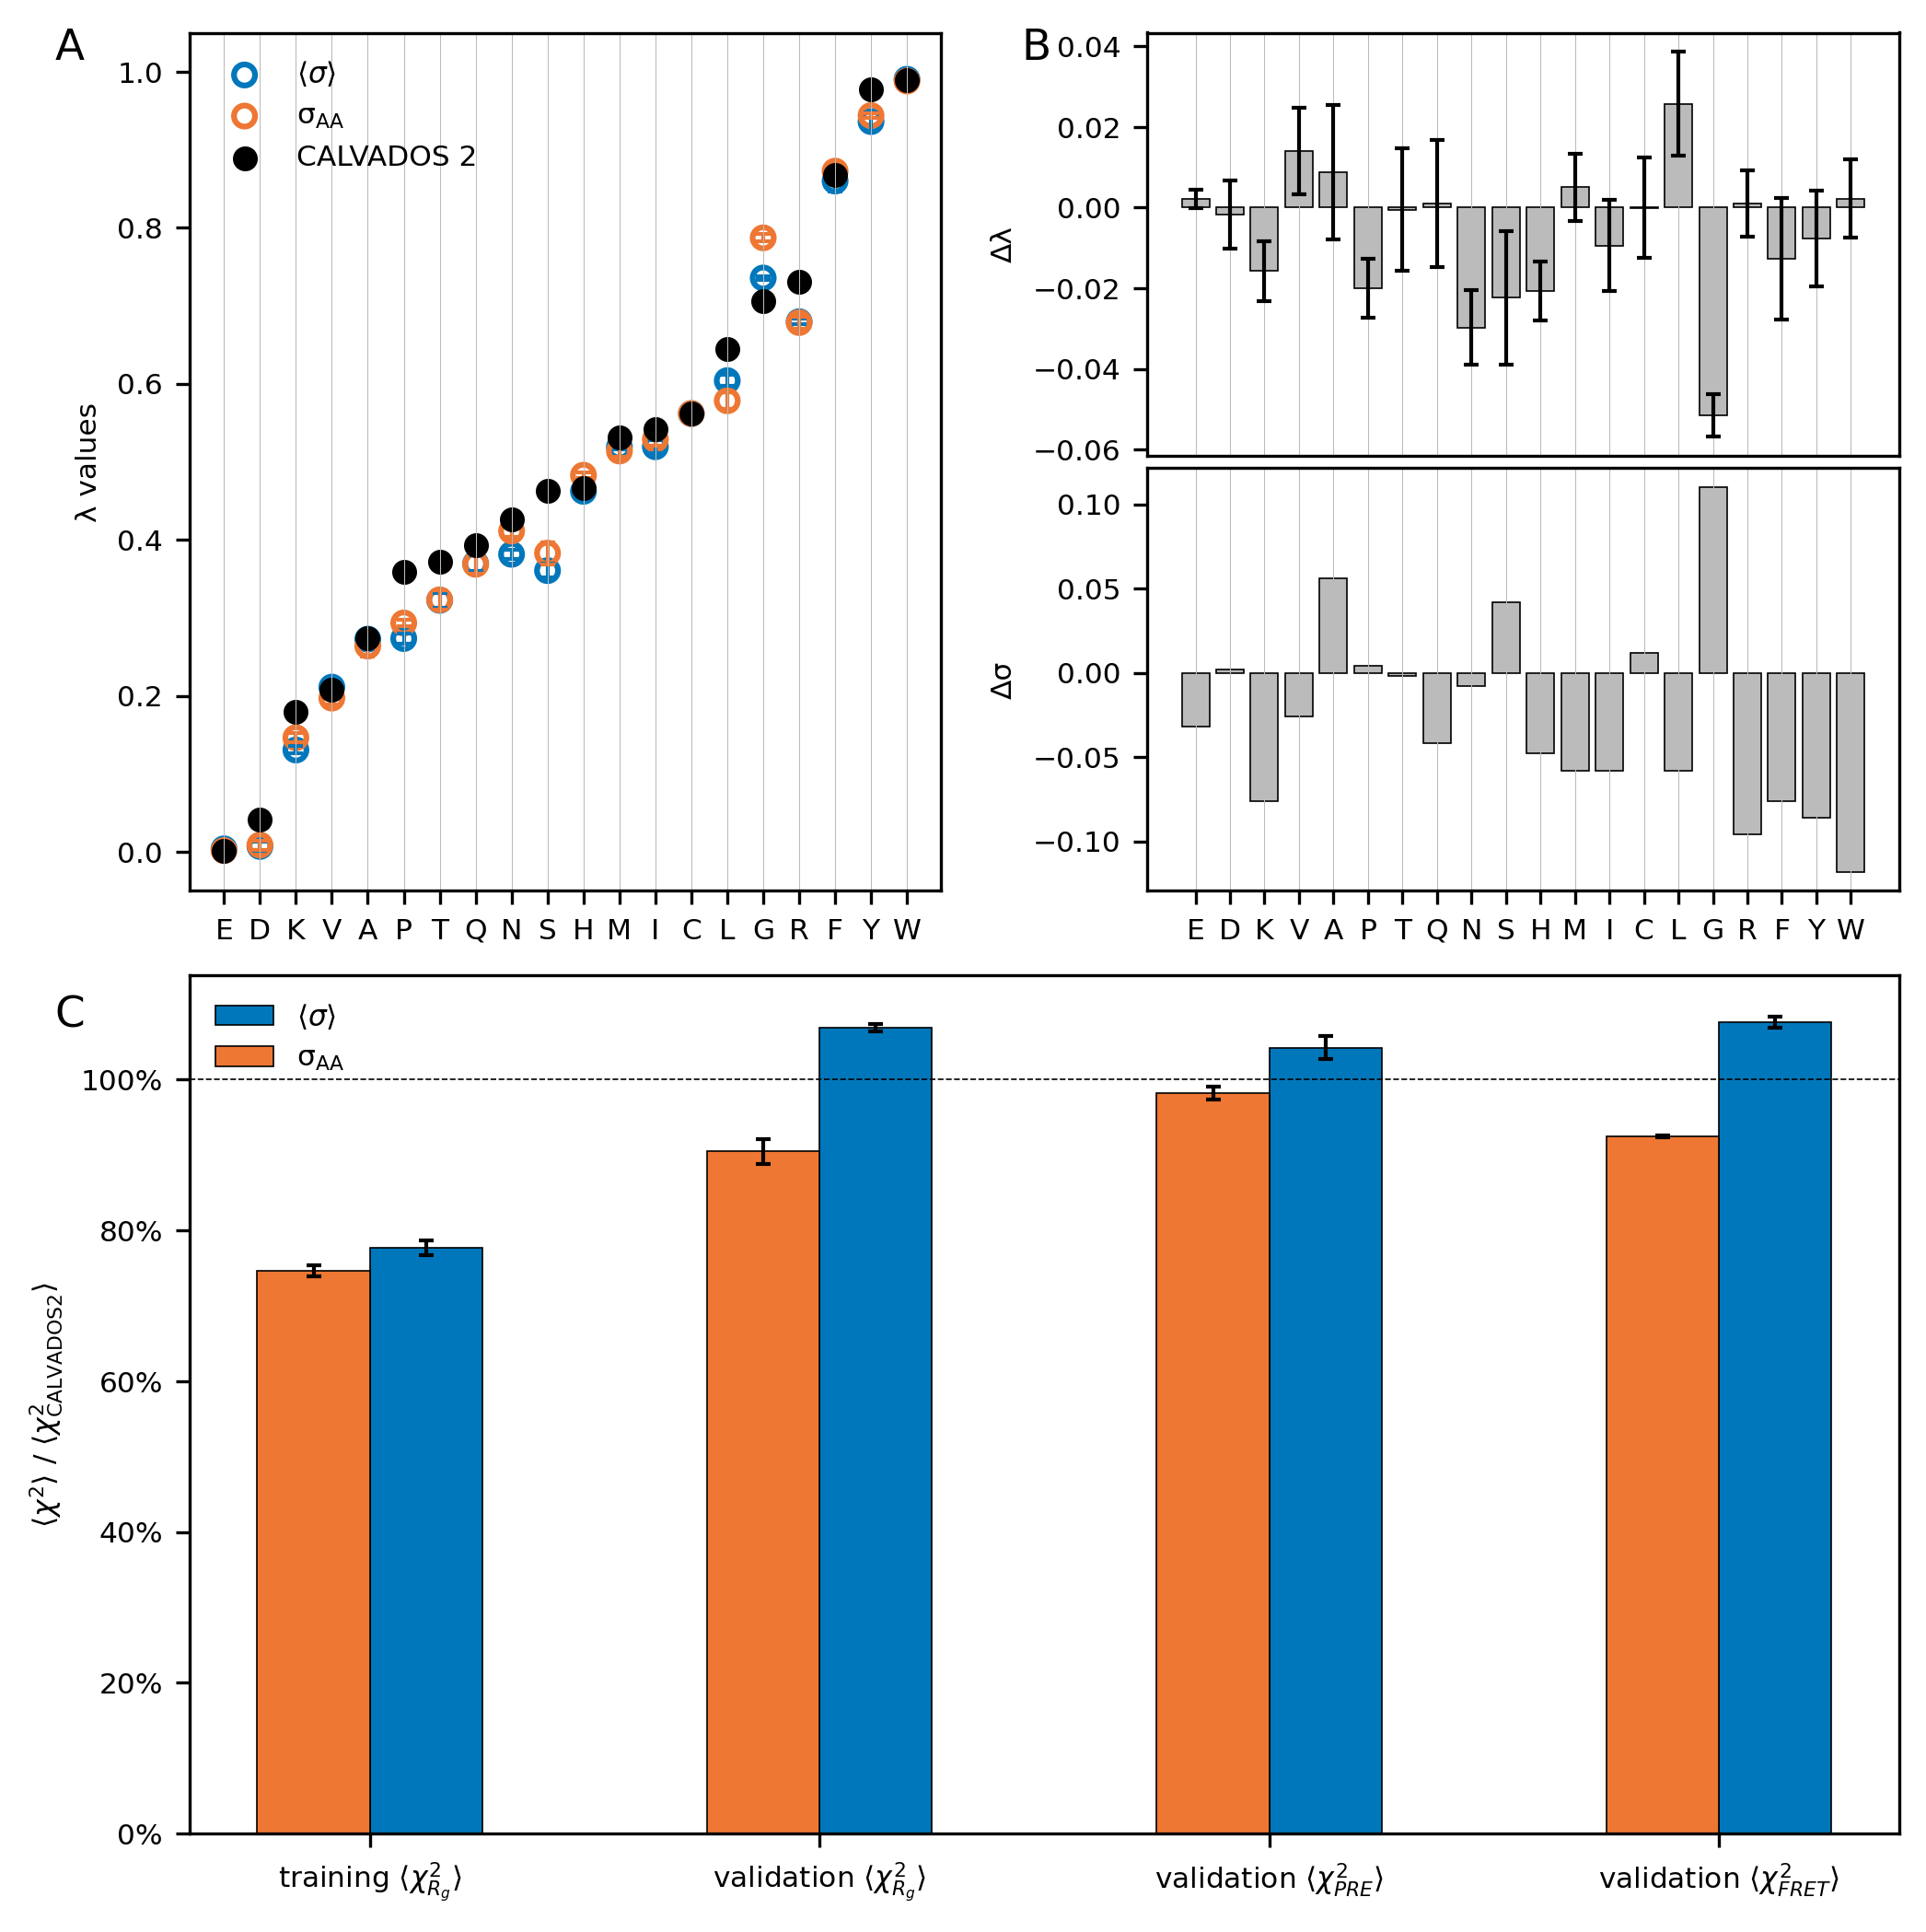

In [6]:
import collections
from ast import literal_eval
import numpy as np
import pandas as pd
import shutil
from color_setting import *
text_size = 7.5
label_size = text_size*1.5
s = 30
linewidth = .1
string_Avesigma = "$\\langleσ\\rangle$"
string_Orisigma = "$\\rm{σ}_{AA}$"
times = 100
mpl.rc('font', size=text_size)

def generatePREloss(cwd, dataset, cycle):
    if not os.path.exists(f"{cwd}/data/{dataset}/proteinsPRE_complete{cycle}.pkl"):
        proteinsPRE = pd.read_pickle(f'{cwd}/data/{dataset}/proteinsPRE_validate.pkl').astype(object)  # can read an empty dataframe
        proteinsPRE["weights"] = False  # pandas needs to be 1.5.2 or above!!!!!!!!
        for record in proteinsPRE.index:
            # tau_c, chi2_pre = optTauC(cwd, dataset, record, cycle, proteinsPRE.loc[record])
            tmp_pkl = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/proteinsPRE_validate_{record}.pkl')
            proteinsPRE.at[record,'tau_c'] = tmp_pkl["tau_c"]
            proteinsPRE.at[record,'chi2_pre'] = tmp_pkl["chi2_pre"]
            proteinsPRE.at[record,'initPREs'] = tmp_pkl["initPREs"]
            if os.path.exists(f'{cwd}/data/{dataset}/{record}/{cycle}/initPREs'):
                shutil.rmtree(f'{cwd}/data/{dataset}/{record}/{cycle}/initPREs')  # delete files recursively
            shutil.copytree(f'{cwd}/data/{dataset}/{record}/{cycle}/calcPREs',f'{cwd}/data/{dataset}/{record}/{cycle}/initPREs')  # copy dir
        proteinsPRE.to_pickle(f"{cwd}/data/{dataset}/proteinsPRE_complete{cycle}.pkl")

def generateFRETloss(cwd, dataset, cycle, new=False):
    fret_err = 0.02
    if not new:
        df_rg = pd.read_csv(f'{cwd}/rg_test_data.csv', index_col=0)
        df_rg = df_rg.sort_values('N', ascending=False)
        df_rg.rel_rg_err_replicas = df_rg.rel_rg_err_replicas.apply(lambda x: literal_eval(x))
        df_ped = pd.read_csv(f'{cwd}/PED_data.csv',index_col=0)
        df_ped.loc[df_ped.drop('p27Kip1').index,'exp_rg'] = df_rg.loc[df_ped.drop('p27Kip1').index,'exp_rg']
        df_ped.loc[df_ped.drop('p27Kip1').index,'exp_rg_err'] = df_rg.loc[df_ped.drop('p27Kip1').index,'exp_rg_err']
        for Edynamic in ["Estatic", "Edynamic1", "Edynamic2"]:
            if not os.path.exists(f"{cwd}/data/{dataset}/proteinsFRET20_complete_{Edynamic}_{cycle}.pkl"):
                df_eff = pd.DataFrame(index=['Nup49', 'NLS', 'NUS', 'IBB', 'NUL', 'Sic1'])
                for name, exp_E in zip(['Nup49', 'NLS', 'NUS', 'IBB', 'NUL'], [.87, .79, .53, .5, .48]):
                    record = name
                    df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret-data-{df_ped.loc[name].N - 1:d}-2.pkl').loc[Edynamic, 'Average']
                    df_eff.loc[name, 'exp_E'] = exp_E

                name = 'Sic1'
                record = name
                df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret-data-1-90.pkl').loc[Edynamic, 'Average']
                df_eff.loc[name, 'exp_E'] = 0.42  # DOI: 10.1021/jacs.0c02088
                df_eff["chi2_fret"] = np.power((df_eff["exp_E"]-df_eff["E"])/fret_err, 2)
                df_eff.to_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_{Edynamic}_{cycle}.pkl")

            if not os.path.exists(f"{cwd}/data/{dataset}/proteinsFRET30_complete_{Edynamic}_{cycle}.pkl"):
                df_eff = pd.DataFrame(index=['Nup49', 'NLS', 'NUS', 'IBB', 'NUL', 'Sic1'])
                for name, exp_E in zip(['Nup49', 'NLS', 'NUS', 'IBB', 'NUL'], [.87, .79, .53, .5, .48]):
                    record = name
                    df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret30-data-{df_ped.loc[name].N - 1:d}-2.pkl').loc[Edynamic, 'Average']
                    df_eff.loc[name, 'exp_E'] = exp_E

                name = 'Sic1'
                record = name
                df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret30-data-1-90.pkl').loc[Edynamic, 'Average']
                df_eff.loc[name, 'exp_E'] = 0.42  # DOI: 10.1021/jacs.0c02088
                df_eff["chi2_fret"] = np.power((df_eff["exp_E"]-df_eff["E"])/fret_err, 2)
                df_eff.to_pickle(f"{cwd}/data/{dataset}/proteinsFRET30_complete_{Edynamic}_{cycle}.pkl")
    else:
        more_fret = pd.read_pickle(f'{cwd}/proteins_fret.pkl')
        for Edynamic in ["Estatic", "Edynamic1", "Edynamic2"]:
            if not os.path.exists(f"{cwd}/data/{dataset}/proteinsFRET10_complete_{Edynamic}_{cycle}.pkl"):
                df_eff = pd.DataFrame(index=list(more_fret.index))
                for name, exp_E in zip(list(more_fret.index), more_fret.loc[list(more_fret.index), 'EC']):
                    record = name
                    df_eff.loc[name, 'E'] = pd.read_pickle(f'{cwd}/data/{dataset}/{record}/{cycle}/fret10-data-{more_fret.loc[record].labels[0]}-{more_fret.loc[record].labels[-1]}.pkl').loc[Edynamic, 'Average']
                    df_eff.loc[name, 'exp_E'] = exp_E
                    df_eff.loc[name, 'fret_err'] = more_fret.loc[record, "EC_err"]
                df_eff["chi2_fret"] = np.power((df_eff["exp_E"] - df_eff["E"]) / df_eff["fret_err"], 2)
                df_eff.to_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_{Edynamic}_{cycle}.pkl")

def get_predictions_opt(cwd, dataset, cycle):
    allproteins = pd.read_pickle(f"{cwd}/IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1/allproteins.pkl")
    IDP_names = list(allproteins.index)
    cal = []
    allproteins = allproteins.loc[IDP_names]
    for name in allproteins.index:
        os.system(f"mkdir -p /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}/{name}/{cycle + 1}")
        os.system(f"cp /projects/prism/people/ckv176/stickiness/src/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}/{name}/{cycle + 1}")
        if not os.path.isfile(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy"):
            df = pd.read_csv(f'{cwd}/data/{dataset}/residues_{cycle}.csv').set_index('three')
            t = md.load_dcd(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.dcd",
                            f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.pdb")
            residues = [res.name for res in t.top.atoms]
            masses = df.loc[residues, 'MW'].values
            masses[0] += 2
            masses[-1] += 16
            # calculate the center of mass
            cm = np.sum(t.xyz * masses[np.newaxis, :, np.newaxis], axis=1) / masses.sum()
            # calculate residue-cm distances
            si = np.linalg.norm(t.xyz - cm[:, np.newaxis, :], axis=2)
            # calculate rg
            rgarray = np.sqrt(np.sum(si ** 2 * masses, axis=1) / masses.sum())
            np.save(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy", rgarray)
        else:
            rgarray = np.load(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy")
        cal_value = np.mean(rgarray)
        cal.append(cal_value)

    allproteins["cal"] = cal
    allproteins['N'] = allproteins['fasta'].apply(lambda x: len(x))
    allproteins = allproteins.sort_values('N', ascending=False)
    allproteins.to_pickle(f"{cwd}/data/{dataset}/predictions.pkl")

    return allproteins, IDP_names

def get_Rgpredictions(cwd, dataset, cycle, Rg_seq):
    allproteins = pd.read_pickle(f"{cwd}/IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1_validate/allproteins_validate.pkl")
    cal = []
    for name in allproteins.index:
        if name in Rg_seq:
            os.system(f"mkdir -p /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}/{name}/{cycle + 1}")
            os.system(f"cp /projects/prism/people/ckv176/stickiness/src/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy /projects/prism/people/ckv176/_2026_cao_scales/src/data/{dataset}/{name}/{cycle + 1}")
            if not os.path.isfile(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy"):
                df = pd.read_csv(f'{cwd}/data/{dataset}/residues_{cycle}.csv').set_index('three')
                t = md.load_dcd(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.dcd",
                                f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.pdb")
                residues = [res.name for res in t.top.atoms]
                masses = df.loc[residues, 'MW'].values
                masses[0] += 2
                masses[-1] += 16
                # calculate the center of mass
                cm = np.sum(t.xyz * masses[np.newaxis, :, np.newaxis], axis=1) / masses.sum()
                # calculate residue-cm distances
                si = np.linalg.norm(t.xyz - cm[:, np.newaxis, :], axis=2)
                # calculate rg
                rgarray = np.sqrt(np.sum(si ** 2 * masses, axis=1) / masses.sum())
                np.save(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy", rgarray)
            else:
                rgarray = np.load(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy")
        else:
            rgarray = []
        cal_value = np.mean(rgarray) if len(rgarray)!=0 else 0
        cal.append(cal_value)

    allproteins["cal"] = cal
    allproteins['N'] = allproteins['fasta'].apply(lambda x: len(x))
    allproteins = allproteins.sort_values('N', ascending=False)

    allproteins_validate = allproteins.loc[Rg_seq]
    allproteins_validate["reset_ratio"] = allproteins_validate["expRgErr"] / allproteins_validate["expRg"]
    # print(allproteins_validate[["reset_ratio"]])
    allproteins_validate["chi2_rg"] = np.power((allproteins_validate["cal"]-allproteins_validate["expRg"])/allproteins_validate["expRgErr"], 2)

    allproteins_validate.to_pickle(f"{cwd}/data/{dataset}/predictions.pkl")

    return allproteins_validate

def compare_resultingLambda():
    cwd = "/projects/prism/people/ckv176/_2026_cao_scales/src"
    rc = 2.4
    replica_range = [1, 2, 3]
    theta = 1950
    cycle = 0
    datasets = [
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_{replica}",
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_{replica}",
    ]

    color_dict = {
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": orange,
    "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": blue,
        "CALVADOS2CAC2_2.4_0.05_0.5_1_validate": "black",
    }
    label_dict = {
        "CALVADOS2CAC2_2.4_0.05_0.5_1_validate": "CALVADOS 2",
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": string_Orisigma,
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": string_Avesigma,
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_2": string_Orisigma,
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_2": string_Avesigma,
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_3": string_Orisigma,
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_3": string_Avesigma,
    }
    offset_dict = {
        "CALVADOS2CAC2_2.4_0.05_0.5_1_validate": -0.25,
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": -0.125,
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": 0.125,
    }

    selected_lambda_dict = collections.defaultdict(list)
    residues_pub = pd.read_csv(f"{cwd}/residues_pub.csv").set_index("one", drop=False)
    residues_pub = residues_pub.sort_values('CALVADOS2')
    fig = plt.figure(figsize=(7, 7), dpi=300)
    outer = gridspec.GridSpec(2, 2)
    outer1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
    outer2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[1], hspace=0.03)
    outer3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[2:])

    ax1 = plt.subplot(outer1[0,0])
    ax2_1 = plt.subplot(outer2[0, 0])
    ax2_2 = plt.subplot(outer2[1, 0])
    ax3 = plt.subplot(outer3[0, 0])

    ax1.set_ylabel("λ values")
    ax3.set_ylabel("$\\langleχ^2\\rangle$ / $\\langleχ^2_{\\text{CALVADOS2}}\\rangle$")
    sorted_aa = residues_pub.one.tolist()
    sorted_aa3 = residues_pub.three.tolist()
    # ax1.set_title(f"theta={theta}, rc={rc} nm")
    ax1.set_xticks(np.arange(len(sorted_aa)))
    ax1.set_xticklabels(labels=sorted_aa)

    for dataset_idx, dataset_str in enumerate(["WeiAve", ""]):
        residues_tmp = pd.DataFrame(index=sorted_aa3, columns=["mean", "std"])
        means_pool = []
        stds_pool = []
        replica_count = 0
        for aa3 in residues_tmp.index:
            pool_tmp = []
            for replica in replica_range:
                dataset = f"IDPs{dataset_str}resetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_{replica}"
                os.system(f"mkdir -p {cwd}/data/{dataset}")
                os.system(f"cp /projects/prism/people/ckv176/stickiness/src/data/{dataset}/{cycle}_chi2.pkl {cwd}/data/{dataset}/")
                os.system(f"cp /projects/prism/people/ckv176/stickiness/src/data/{dataset}/residues_{cycle}.csv {cwd}/data/{dataset}/")
                os.system(f"cp /projects/prism/people/ckv176/stickiness/src/data/{dataset}/residues_-1.csv {cwd}/data/{dataset}/")
                chi2 = pd.read_pickle(f"{cwd}/data/{dataset}/{cycle}_chi2.pkl")
                selected_lambdas = chi2.loc[list(chi2.index)[np.argmin(list(chi2.cost))], "lambdas"]
                pd.read_csv(f"{cwd}/data/{dataset}/residues_{cycle}.csv").set_index("one")[["three", "MW", "lambdas", "sigmas", "q"]].to_csv(f"{cwd}/data/{dataset}/chosen.csv")
                pool_tmp.append(selected_lambdas.loc[aa3])
                """if replica == 1:
                    selected_lambda_dict[label_dict[dataset]] = selected_lambdas.loc[sorted_aa3].tolist()"""
                if replica_count < 3:
                    selected_lambda_dict[label_dict[dataset]].append(selected_lambdas.loc[sorted_aa3].tolist())
                    replica_count += 1

            means_pool.append(np.mean(pool_tmp))
            stds_pool.append(np.std(pool_tmp))
        residues_tmp["mean"] = means_pool
        residues_tmp["std"] = stds_pool

        dataset = f"IDPs{dataset_str}resetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1"
        print(residues_tmp.loc[sorted_aa3, "std"])
        ax1.scatter(range(len(sorted_aa)), residues_tmp.loc[sorted_aa3, "mean"], s=s, marker="o", label=f"{label_dict[dataset]}", c='None', edgecolor=color_dict[dataset], linewidth=linewidth * 15)
        ax1.errorbar(range(len(sorted_aa)), residues_tmp.loc[sorted_aa3, "mean"], yerr=residues_tmp.loc[sorted_aa3, "std"], lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, color=color_dict[dataset])

    ax1.scatter(range(len(sorted_aa)), residues_pub.loc[sorted_aa].CALVADOS2, s=s, label="CALVADOS 2", c="black", zorder=2)

    for aa_idx in range(20):
        ax1.vlines(aa_idx, ymin=-0.05, ymax=1.15, linewidth=linewidth*2.5, color=grey)
        ax2_1.vlines(aa_idx, ymin=-0.2, ymax=0.2, linewidth=linewidth * 2.5, color=grey)
        ax2_2.vlines(aa_idx, ymin=-0.2, ymax=0.2, linewidth=linewidth * 2.5, color=grey)

    ax1.legend(edgecolor="white", frameon=False)
    ax1.set_ylim((-0.05, 1.05))

    residues_test = pd.read_csv(f"{cwd}/IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1/residues_-1.csv").set_index("one")
    # print(selected_lambda_dict)
    if len(datasets) == 2:
        print(np.array(selected_lambda_dict[string_Avesigma]).std(axis=0))
        print(np.array(selected_lambda_dict[string_Orisigma]).std(axis=0))
        ax2_1.bar(sorted_aa, np.array(selected_lambda_dict[string_Avesigma]).mean(axis=0) - np.array(selected_lambda_dict[string_Orisigma]).mean(axis=0), label="Ori.", color=grey, edgecolor="black", linewidth=linewidth * 4)
        ax2_1.errorbar(sorted_aa, np.array(selected_lambda_dict[string_Avesigma]).mean(axis=0) - np.array(selected_lambda_dict[string_Orisigma]).mean(axis=0), yerr=np.sqrt(np.array(selected_lambda_dict[string_Avesigma]).std(axis=0)**2+np.array(selected_lambda_dict[string_Orisigma]).std(axis=0)**2), lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, color="black")
    # ax2_1.set_title(f"{string_Avesigma}-{string_Orisigma}")
    ax2_1.set_ylabel("Δλ")
    ax2_1.set_xticklabels(labels=[])
    ax2_1.set_xticks([])
    ax2_2.bar(sorted_aa, residues_test.loc["A", "sigmas"] - residues_pub.loc[sorted_aa, "sigmas"], color=grey, edgecolor="black", linewidth=linewidth*4)
    ax2_2.set_ylabel("Δσ")

    denominator = np.array([])
    # validateRg_pro = ["V2", "V3", "V4", "V5", "ER_NTD", "CTR_XRCC4", "Nlp441_543", "CTir", "TRPV4", "Red1", "dChMINUS_Rg", "sNhPLUS_Rg", 'ERNTD_WT', 'HMPVP_NTD', 'SMAD4_linker', 'SMAD2_linker', 'NLS_Rg', 'IBB_Rg', 'NUL_Rg', 'NUS_Rg', 'Nsp1_Rg', 'Nup49_Rg', 'N98_Rg']
    validateRg_pro =   ["V2", "V3", "V4", "V5", "ER_NTD", "CTR_XRCC4",               "CTir", "TRPV4", "Red1", "dChMINUS_Rg", "sNhPLUS_Rg",             "HMPVP_NTD",                 'SMAD2_linker', 'NLS_Rg', 'IBB_Rg', 'NUL_Rg', 'NUS_Rg', 'Nsp1_Rg', 'Nup49_Rg', 'N98_Rg']
    for dataset_idx, dataset_str in enumerate(["CALVADOS2CAC2_2.4_0.05_0.5_1_validate", "WeiAve", ""]):
        valRg_pool = []
        valPre_pool = []
        valFret_pool = []
        valFretEstatic_pool = []
        valFretEdynamic1_pool = []
        optRg_pool = []
        for c_idx, replica in enumerate(replica_range):
            if dataset_str in ["", "WeiAve"]:
                dataset = f"IDPs{dataset_str}resetErrC2_priorNominmaxCAC2_based_2.4_{theta}.0_0.5_{replica}_validate"
                cycle = 0
            else:
                dataset = dataset_str
                cycle = -1
            
            os.system(f"mkdir -p {cwd}/data/{dataset}")
            os.system(f"mkdir -p {cwd}/data/{dataset}")
            os.system(f"cp /projects/prism/people/ckv176/stickiness/src/data/{dataset}/*.pkl {cwd}/data/{dataset}/")
            os.system(f"cp /projects/prism/people/ckv176/stickiness/src/data/{dataset}/residues_{cycle}.csv {cwd}/data/{dataset}/")
            
            validateRg = get_Rgpredictions(cwd, dataset, cycle, validateRg_pro)
            valRg_pool.append(np.mean(validateRg["chi2_rg"]))
            generatePREloss(cwd, dataset, cycle+1)
            generateFRETloss(cwd, dataset, cycle+1)
            generateFRETloss(cwd, dataset, cycle + 1, new=True)
            valPre_pool.append(np.mean(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsPRE_complete{cycle+1}.pkl").chi2_pre))
            # print(f"data/{dataset}, \n {pd.read_pickle(f'{cwd}/data/{dataset}/proteinsPRE_complete{cycle+1}.pkl').chi2_pre}")
            valFret_pool.append(np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Edynamic2_{cycle+1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Edynamic2_{cycle+1}.pkl").chi2_fret)))
            valFretEstatic_pool.append(np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Estatic_{cycle + 1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Estatic_{cycle + 1}.pkl").chi2_fret)))
            valFretEdynamic1_pool.append(np.mean(list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET20_complete_Edynamic1_{cycle + 1}.pkl").chi2_fret) + list(pd.read_pickle(f"{cwd}/data/{dataset}/proteinsFRET10_complete_Edynamic1_{cycle + 1}.pkl").chi2_fret)))
            predictions_tmp = get_predictions_opt(cwd, dataset[:-9], cycle)[0]
            predictions_tmp["ratio"] = predictions_tmp["expRgErr"] / predictions_tmp["expRg"]
            # print(predictions_tmp[["ratio"]])
            optRg_pool.append(np.mean(np.power((predictions_tmp["cal"]-predictions_tmp["expRg"])/predictions_tmp["expRgErr"], 2)))
            if dataset == "CALVADOS2CAC2_2.4_0.05_0.5_1_validate":
                break
        if dataset_str in ["", "WeiAve"]:
            print(f"{dataset_str}, {optRg_pool}")
            optRg_pool = np.array(optRg_pool) / denominator[0]
            valRg_pool = np.array(valRg_pool) / denominator[1]
            valPre_pool = np.array(valPre_pool) / denominator[2]
            valFret_pool = np.array(valFret_pool) / denominator[3]


        optchi2_rg = np.mean(optRg_pool)
        optchi2_rg_err = np.std(optRg_pool)/np.sqrt(len(optRg_pool))

        valchi2_rg = np.mean(valRg_pool)
        valchi2_rg_err = np.std(valRg_pool)/np.sqrt(len(valRg_pool))

        valchi2_pre = np.mean(valPre_pool)
        valchi2_pre_err = np.std(valPre_pool)/np.sqrt(len(valPre_pool))

        valchi2_fret = np.mean(valFret_pool)
        valchi2_fret_err = np.std(valFret_pool)/np.sqrt(len(valFret_pool))

        valchi2_fretEstatic = np.mean(valFretEstatic_pool)
        valchi2_fretEstatic_err = np.std(valFretEstatic_pool)/np.sqrt(len(valFretEstatic_pool))

        valchi2_fretEdynamic1 = np.mean(valFretEdynamic1_pool)
        valchi2_fretEdynamic1_err = np.std(valFretEdynamic1_pool)/np.sqrt(len(valFretEdynamic1_pool))

        if dataset_str in ["", "WeiAve"]:
            dataset = f"IDPs{dataset_str}resetErrC2_priorNominmaxCAC2_based_2.4_{theta}.0_0.5_1"
            ax3.bar(np.array(range(4))+offset_dict[dataset], np.array([optchi2_rg, valchi2_rg, valchi2_pre, valchi2_fret]), color=color_dict[dataset], label=label_dict[dataset], width=0.25, edgecolor="black", linewidth=linewidth * 4)
            ax3.errorbar(np.array(range(4))+offset_dict[dataset], np.array([optchi2_rg, valchi2_rg, valchi2_pre, valchi2_fret]), yerr=[valchi2_rg_err, valchi2_pre_err, valchi2_fret_err, optchi2_rg_err], lw=0, ms=0, elinewidth=1, capsize=2, capthick=1, c="black")
        else:
            denominator = np.array([optchi2_rg, valchi2_rg, valchi2_pre, valchi2_fret])

    string_valchi2_rg = "validation $\\langleχ^2_{R_g}\\rangle$"
    string_optchi2_rg = "training $\\langleχ^2_{R_g}\\rangle$"
    string_valchi2_pre = "validation $\\langle\chi^2_{PRE}\\rangle$"
    string_valchi2_fret = "validation $\\langle\chi^2_{FRET}\\rangle$"

    ax3.hlines(y=1.0, xmin=-0.4, xmax=3.4, colors="black", linestyle="dashed", linewidth=linewidth * 4)
    ax3.set_yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=["0%", "20%", "40%", "60%", "80%", "100%"])
    ax3.set_xticks(ticks=[0,1,2,3], labels=[string_optchi2_rg, string_valchi2_rg, string_valchi2_pre, string_valchi2_fret])
    ax3.legend(edgecolor="white", frameon=False)
    ax3.set_xlim(-0.4, 3.4)
    fig.text(0.03, 0.97, 'A', fontsize=label_size)
    fig.text(0.53, 0.97, 'B', fontsize=label_size)
    fig.text(0.03, 0.47, 'C', fontsize=label_size)
    plt.tight_layout()
    plt.savefig(f"{cwd}/resulting_lambdas.pdf")
    plt.show()

compare_resultingLambda()

training_data: ['tau35', 'GHRICD', 'p532070', 'Ash1', 'CTD2', 'ColNT', 'hNL3cyt', 'SH4UD', 'Sic1', 'FhuA', 'K10', 'K27', 'K25', 'K32', 'K23', 'K44', 'A1', 'M12FP12Y', 'P7FM7Y', 'M9FP6Y', 'M8FP4Y', 'M9FP3Y', 'M10R', 'M6R', 'P2R', 'P7R', 'M3RP3K', 'M6RP6K', 'M10RP10K', 'M4D', 'P4D', 'P8D', 'P12D', 'P12E', 'P7KP12D', 'P7KP12Db', 'M12FP12YM10R', 'M10FP7RP12D', 'Hst5', 'Hst52', 'aSyn140', 'ACTR', 'RNaseA', 'p15PAF', 'CoRNID', 'PNt', 'PNtS1', 'PNtS4', 'PNtS5', 'PNtS6', 'A1S@S150', 'ANAC046', 'AavLEA1', 'BMAL1P624A', 'Calpastatin', 'D91_FATZ1', 'DSS1', 'DomainV', 'ED1', 'ED2', 'ED3', 'ED4', 'ERD10', 'ERD14', 'FCP1', 'Fez1', 'GON7', 'GRB14_PIR', 'HAdV5E1A', 'HeV_PNT3_3Y3A', 'HeV_PNT3_CTD', 'HeV_PNT3_CTD_3Y3A', 'HeV_PNT3_WT', 'HvASR1', 'MAP2c', 'MenVL', 'MetC', 'Msh6_NTR', 'NHE6cmdd', 'N_FATZ1', 'NiV_PNT3_WT', 'P300', 'PARCL', 'PNtdeltaPG', 'PTMA', 'RNaseE603_850', 'S106_128', 'S110_125', 'S129_146', 'S130_143', 'S26_45', 'S45_64', 'S4L', 'S66_81', 'S67_86', 'S82_96', 'S87_105', 'TIF2NRID', 'TR

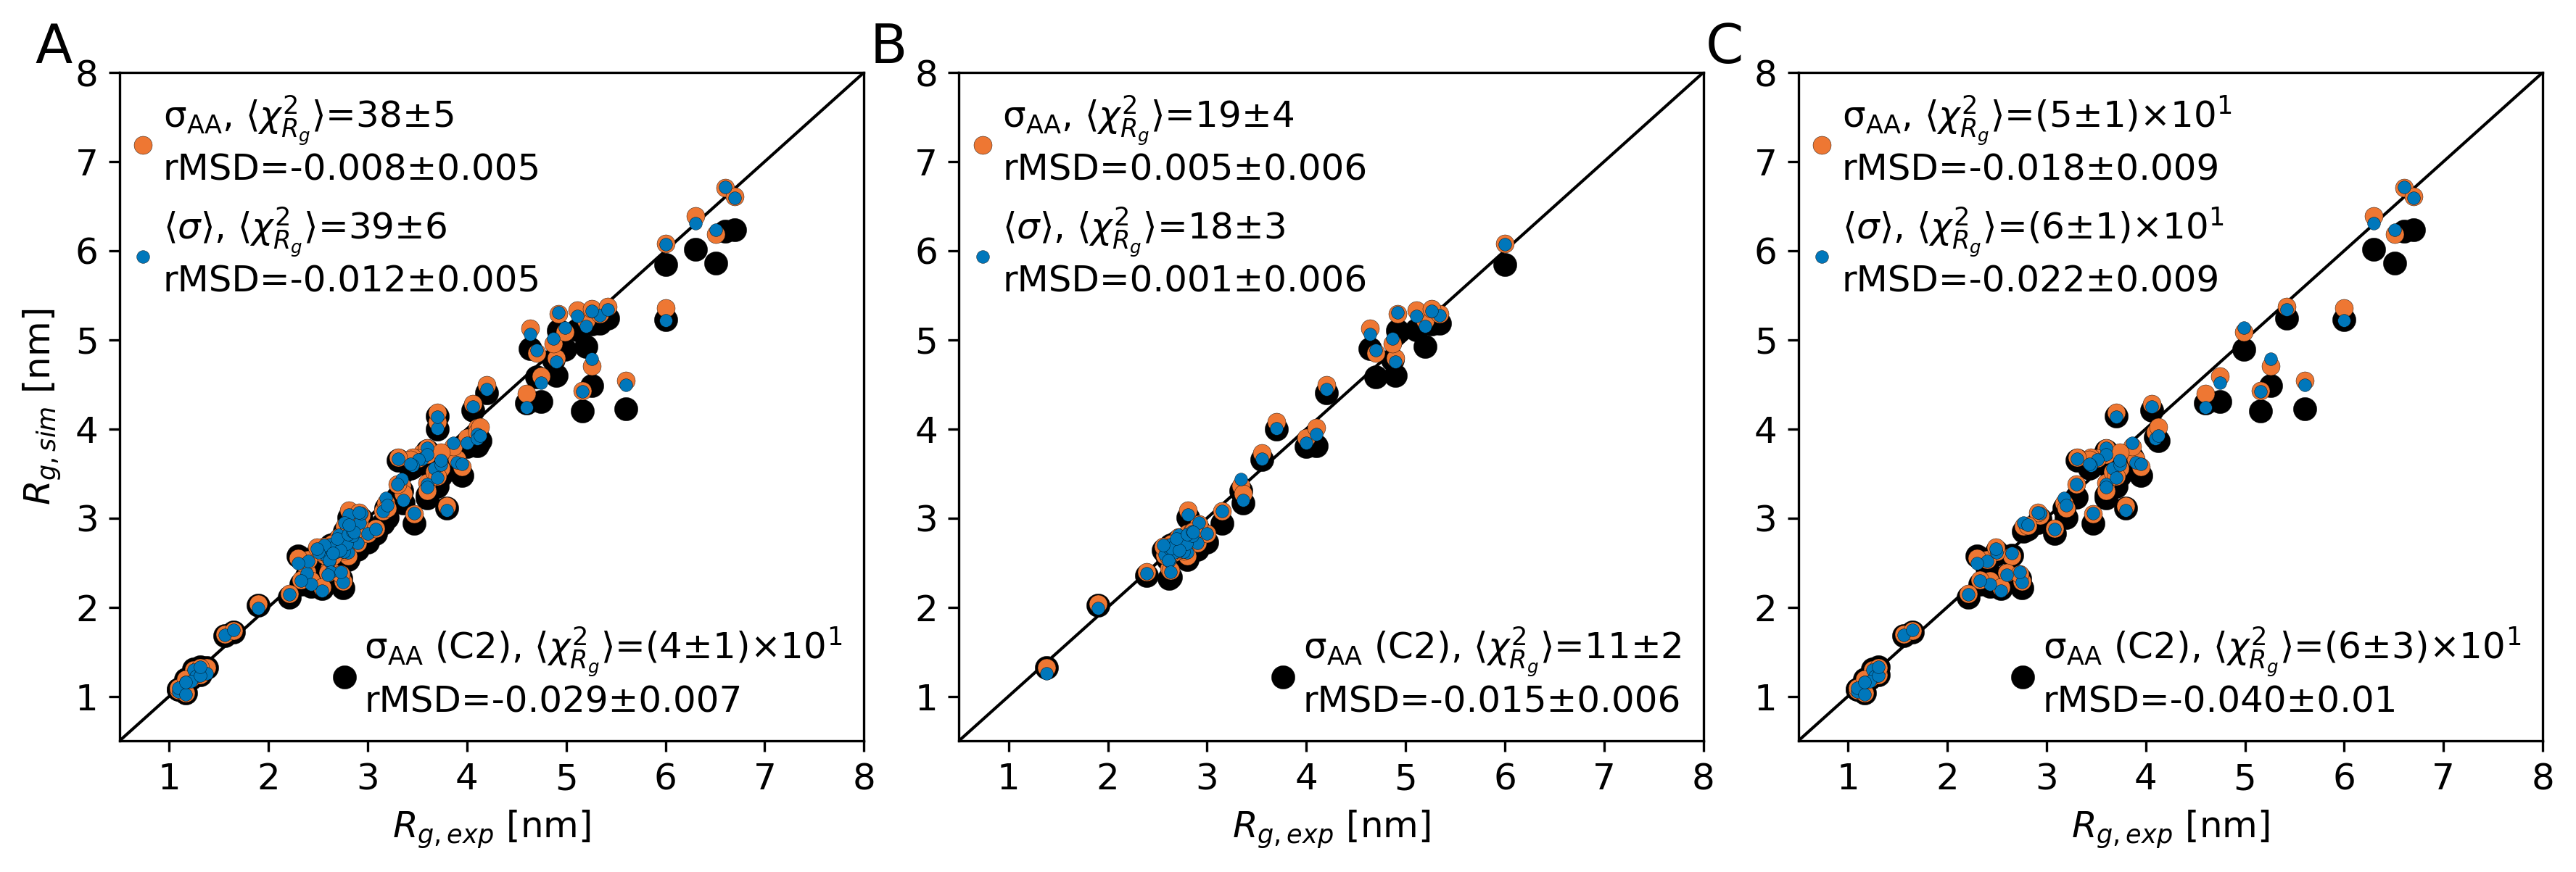

In [10]:
cyan = "#33BBEE"
blue = "#0077BB"
orange = "#EE7733"
yellow = "#f0e442"
magenta = "#EE3377"
green = "#009988"
red = "#CC3311"
grey = "#BBBBBB"
CALVADOS2_CA = "$\\rm{CALVADOS2}_{C\\mathit{\\alpha}}$"
CALVADOS2_COM = "$\\rm{CALVADOS2}_{COM}$"
CALVADOS2_SCCOM = "$\\rm{CALVADOS2}_{SCCOM}$"
string_chi2_rg = "$\\langleχ^2_{R_g}\\rangle$"
CA = '$\\rm{C}\\mathit{\\alpha}$'
string_Avesigma = "$\\langleσ\\rangle$"
string_Orisigma = "$\\rm{σ}_{AA}$"
CALVADOS3_COM = "$\\rm{CALVADOS3}_{COM}$"
from scipy.stats import pearsonr
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
import pandas
import os
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import sys
from matplotlib.colors import LogNorm
from scipy.optimize import least_squares
import mdtraj as md
import matplotlib.pyplot as plt
import pandas as pd
times=100
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.set_printoptions(suppress=True)  # Cancel scientific counting display
np.set_printoptions(threshold=np.inf)
import matplotlib as mpl

def determineSigniDigit(value, error):
    print(f"{value}\u00B1{error}")
    if (str(value) in ["nan"]) or (str(error) in ["nan"]):
        return f"{value}\u00B1{error}"
    # not perfect
    real_decimal_list = str(error).split(".")
    real_int = int(real_decimal_list[0])
    if real_int != 0:
        exponent = len(str(real_int))-1
        if exponent==0:
            Digit = 0
            scd = False
        else:
            Digit = exponent
            scd = True
    else:
        decimal_str = real_decimal_list[1]
        Digit = 1
        scd = False  # scientific counting display
        for i in decimal_str:
            if i=="0":
                Digit += 1
            else:
                break
    # print(Digit, scd)
    if scd:
        value = value/(10**Digit)
        error = error/(10**Digit)
        first_part = int(np.round(value+1E-8, 0))  # +1E-8 used for rounding
        second_part = int(np.round(error+1E-8, 0))
        science = "$\\times{10}^%d$" % (Digit)
        output = f"({first_part}\u00B1{second_part}){science}"
    else:
        if Digit==0:
            first_part = int(np.round(value+1E-8, Digit))
            second_part = int(np.round(error+1E-8, Digit))
            output = f"{first_part}\u00B1{second_part}"
        else:
            first_part = np.round(value, Digit)
            tmp_size = len(str(first_part).split(".")[1])
            second_part = np.round(error, Digit)

            output = f"{first_part}{''.join(['0']*(Digit-tmp_size))}\u00B1{second_part}"

    print(output)
    return output

# check residues_pair=0 influence on single-chain Rg. Successfully reproduced C3 results.
def get_predictions(cwd, dataset, cycle, bootstrapping=False):
    allproteins = pd.read_pickle(f"{cwd}/data/{dataset}/allproteins.pkl")
    IDP_names = list(allproteins.index)
    cal, bt = [], []

    for name in allproteins.index:
        """if "@" in name:
            if name in multidomain_names:
                multidomain_names.remove(name)
            else:
                IDP_names.remove(name)"""
    allproteins = allproteins.loc[IDP_names]
    for name in allproteins.index:
        if not os.path.isfile(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy"):
            df = pd.read_csv(f'{cwd}/data/{dataset}/residues_{cycle}.csv').set_index('three')
            t = md.load_dcd(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.dcd",
                            f"{cwd}/data/{dataset}/{name}/{cycle + 1}/{name}.pdb")
            residues = [res.name for res in t.top.atoms]
            masses = df.loc[residues, 'MW'].values
            masses[0] += 2
            masses[-1] += 16
            # calculate the center of mass
            cm = np.sum(t.xyz * masses[np.newaxis, :, np.newaxis], axis=1) / masses.sum()
            # calculate residue-cm distances
            si = np.linalg.norm(t.xyz - cm[:, np.newaxis, :], axis=2)
            # calculate rg
            rgarray = np.sqrt(np.sum(si ** 2 * masses, axis=1) / masses.sum())
            np.save(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy", rgarray)

        else:
            rgarray = np.load(f"{cwd}/data/{dataset}/{name}/{cycle + 1}/Rg_traj.npy")

        if bootstrapping:
            numkeep = int(len(rgarray) * 0.9)
            res = np.zeros(shape=(times, numkeep))  # (times, n_traj)
            for time in range(times):
                res[time] = np.random.choice(rgarray, size=numkeep, replace=False)
            cal_res = np.mean(res, axis=1)
        cal_value = np.mean(rgarray)

        cal.append(cal_value)
        bt.append(cal_res)
        """if name in multidomain_names:
            ssdomains = get_ssdomains(name, f"{cwd}/domains.yaml")
            len_domain = 0
            for ssdomain in ssdomains:
                len_domain += len(ssdomain)
            bsheet_per.append(np.load(f"{cwd}/relax_stride/{name}_SScount.npy", allow_pickle=True).item()["E"]/len_domain)"""

    allproteins["cal"] = cal
    allproteins["bt"] = bt
    allproteins['N'] = allproteins['fasta'].apply(lambda x: len(x))
    allproteins = allproteins.sort_values('N', ascending=False)
    allproteins.to_pickle(f"{cwd}/data/{dataset}/predictions.pkl")

    return allproteins, IDP_names


import random
import numpy as np


def bootstrap_pearsonr(sim, exp, times=1000):
    indices = np.arange(sim.size)
    bootstrap_pr = []
    for _ in range(times):
        picked = random.choices(indices, k=indices.size)
        bootstrap_pr.append(pearsonr(exp[picked], sim[picked])[0])
    pr_err = np.std(bootstrap_pr)
    return pr_err


def bootstrap(sim, times=1000):
    indices = np.arange(sim.size)
    res_list = []
    for _ in range(times):
        picked = random.choices(indices, k=indices.size)
        res_list.append(sim[picked].mean())
    res_err = np.std(res_list)
    return res_err


text_size = 12
label_size = text_size * 1.5
s = 30
linewidth = .1
times = 100
mpl.rc('font', size=text_size)


def fig1_2(ax_list):
    variants = ['A1', 'M12FP12Y', 'P7FM7Y', 'M9FP6Y',
                'M8FP4Y', 'M9FP3Y', 'P23GM23SM12FP12Y',
                'M10R', 'M6R', 'P2R', 'P7R', 'M3RP3K',
                'M10GP10S', 'M20GP20S', 'P23GM23SP7FM7Y',
                'M6RP6K', 'M10RP10K', 'M4D', 'P4D',
                'P8D', 'P12D', 'P12E', 'P23GM23S', 'M30GP30S',
                'P7KP12D', 'P7KP12Db', 'M12FP12YM10R',
                'M10FP7RP12D', 'M14NP14Q', 'M23SP23T',
                ]
    cwd = "/projects/prism/people/ckv176/_2026_cao_scales/src"
    C2_training = list(pd.read_pickle(f"{cwd}/IDPsRgs_C2.pkl").index)
    C2_training.remove("CAHSD")  # salt concentration is too low
    whole_training = list(pd.read_pickle(f"{cwd}/IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1/allproteins.pkl").index)
    bootstrapping = True
    # use current lambda values to simulate next cycle
    label_dict = {
        "CALVADOS2CAC2_2.4_0.05_0.5_1": f"{string_Orisigma} (C2)",
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": string_Orisigma,
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": string_Avesigma,

                  }

    datasets_dict = {
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": 0,
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": 0,
        "CALVADOS2CAC2_2.4_0.05_0.5_1": -1,
                      }
    # use the current to take next cycle results

    color_dict = {
        "CALVADOS2CAC2_2.4_0.05_0.5_1": "black",
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": orange,
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": blue,
    }
    zorder_dict = {
        "CALVADOS2CAC2_2.4_0.05_0.5_1": 95,
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": 99,
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": 98,
}
    s_dict = {
        "IDPsresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": s*1.2,
        "CALVADOS2CAC2_2.4_0.05_0.5_1": s*2,
        "IDPsWeiAveresetErrC2_priorNominmaxCAC2_based_2.4_1950.0_0.5_1": s*0.6,
    }
    titles_list = ["All training proteins", "OLD C2 training data", "NEW training data"]
    datapoints = [C2_training+list(np.setdiff1d(whole_training, C2_training)), C2_training, list(np.setdiff1d(whole_training, C2_training))]
    for training_data_idx, training_data in enumerate(datapoints):
        print(f"training_data: {training_data}")
        ax = ax_list[training_data_idx]
        for dataset_idx, dataset in enumerate(list(datasets_dict.keys())):
            print(dataset)
            cycle = datasets_dict[dataset]
            predictions, IDP_names = get_predictions(cwd, dataset, cycle, bootstrapping=bootstrapping)
            predictions = predictions.loc[training_data]
            names = training_data
            Rg_exp = np.array(predictions.loc[names]["expRg"])
            Rg_cal = np.array(predictions.loc[names]["cal"])
            Error = np.array(predictions.loc[names]["expRgErr"])
            chi2_Rg = np.power((Rg_exp - Rg_cal) / Error, 2)
            bt_error = bootstrap(chi2_Rg, times=times)
            # print(predictions[["expRg", "expRgErr"]])
            predictions["RD"] = (Rg_cal - Rg_exp) / Rg_exp
            bt_RD = bootstrap(predictions["RD"].to_numpy(), times=times)

            if dataset_idx == 0:
                predictions["absRD"] = np.abs((Rg_cal - Rg_exp) / Rg_exp * 100)
                predictions = predictions.sort_values("absRD", ascending=True)
                sorted_names = list(predictions.index)
            assert len(sorted_names) != 0
            predictions = predictions.loc[sorted_names]
            if dataset_idx == 0:
                legends_1 = ax.scatter(predictions.loc[names]["expRg"], predictions.loc[names]["cal"],
                           label=f"{label_dict[dataset]}, {string_chi2_rg}={determineSigniDigit(chi2_Rg.mean(), bt_error)}\nrMSD={determineSigniDigit(predictions['RD'].mean(), bt_RD)}",
                           color=color_dict[dataset], s=s_dict[dataset], zorder=zorder_dict[dataset], marker="o", edgecolor="black",linewidth=linewidth)
            elif dataset_idx == 1:
                legends_2 = ax.scatter(predictions.loc[names]["expRg"], predictions.loc[names]["cal"],
                           label=f"{label_dict[dataset]}, {string_chi2_rg}={determineSigniDigit(chi2_Rg.mean(), bt_error)}\nrMSD={determineSigniDigit(predictions['RD'].mean(), bt_RD)}",
                           color=color_dict[dataset], s=s_dict[dataset], zorder=zorder_dict[dataset], marker="o", edgecolor="black",linewidth=linewidth)
            else:
                legends_3 = ax.scatter(predictions.loc[names]["expRg"], predictions.loc[names]["cal"],
                           label=f"{label_dict[dataset]}, {string_chi2_rg}={determineSigniDigit(chi2_Rg.mean(), bt_error)}\nrMSD={determineSigniDigit(predictions['RD'].mean(), bt_RD)}",
                           color=color_dict[dataset], s=s_dict[dataset], zorder=zorder_dict[dataset], marker="o", edgecolor="black",linewidth=linewidth)
                
        first_legend = ax.legend(handles=[legends_1, legends_2], loc='upper left', edgecolor="white", frameon=False, borderpad=.1, handlelength=.1, handletextpad=.5)
        ax.add_artist(first_legend)
        ax.legend(handles=[legends_3], loc='lower right', edgecolor="white", frameon=False, borderpad=.1, handlelength=.1, handletextpad=.5)
        ax.tick_params(axis='y')
        ax.tick_params(axis='x')
        ax.set_xlabel("$R_{g,exp}$ [nm]")
        if training_data_idx==0:
            ax.set_ylabel("$R_{g,sim}$ [nm]")
        ax.plot([0, 8], [0, 8], color="black", linewidth=10 * linewidth, zorder=0)
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
        ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.5, 8)

fig = plt.figure(figsize=(12, 4), dpi=300)
ax1 = plt.subplot2grid((1, 3), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1, 3), (0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((1, 3), (0, 2), rowspan=1, colspan=1)

fig.text(0.02, 0.95, 'A', fontsize=label_size)
fig.text(0.34, 0.95, 'B', fontsize=label_size)
fig.text(0.66, 0.95, 'C', fontsize=label_size)

fig1_2([ax1, ax2, ax3])
plt.tight_layout()
plt.show()
fig.savefig(f'/projects/prism/people/ckv176/_2026_cao_scales/src/training_scatter.pdf', bbox_inches='tight')